In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sipm.recon.WaveformAnalyzer as wfa
import sipm.recon.WaveformDataset as wfd
from scipy.optimize import curve_fit
import ROOT
import sipm.util.functions as func
from numpy.random import normal
import pandas as pd
import glob
import ROOT

plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Welcome to JupyROOT 6.26/06


In [2]:
!pwd

/home/as111/sipm-analysis


In [9]:
# data folder
gain = 2.0
data = {}
path = "/scratch/gpfs/as111/results/"
positions = ['top','bottom']
channels = [-1, 0, 1, 2, 3] # channel -1 contains total_pe and fprompt
voltages = [67]
tags = {'Backgrounds':'no_gamma',
        'Na-22':'gamma_na22',
        'Cs-137':'gamma_cs137',
        'Ba-133':'gamma_ba133'}
cond = list(tags.keys())
for i,c in enumerate(cond):
    data[c] = {}
    for pos in positions:
        data[c][pos] = {}
        coinc = 'software'
        for ch in channels:
            data[c][pos][ch] = {}
            for volt in voltages:
                data[c][pos][ch][volt] = []
                if c=='Backgrounds' and pos=='top':
                    date = '2023-05-12'
                else:
                    date = '2023-05-19'
                files = glob.glob(f"{path}{date}/*volt_{volt}_pos_{pos}*coinc_{coinc}_cond_{tags[c]}*run*[!_wf].h5")
                if ch==-1:
                    print(files)
                for f in files:
                    df = pd.read_hdf(f, key=f'{volt}/{ch}')
                    data[c][pos][ch][volt].append(df)
                    df = None # clear memory
                data[c][pos][ch][volt] = pd.concat(data[c][pos][ch][volt], ignore_index=True)
print('keys (ch=-1): ', list(data[cond[0]][positions[0]][-1][67].keys()))
print('keys (ch=0,1,2,3): ', list(data[cond[0]][positions[0]][0][67].keys()))
print(f'bkg: {len(data[cond[0]][positions[0]][-1][67]["total_pe"])} events')
print(f'gamma: {len(data[cond[1]][positions[0]][-1][67]["total_pe"])} events')

['/scratch/gpfs/as111/results/2023-05-12/2023-05-12_volt_67_pos_top_light_scintillation_coinc_software_cond_no_gamma_noveto_lead_overnight_run9.h5', '/scratch/gpfs/as111/results/2023-05-12/2023-05-12_volt_67_pos_top_light_scintillation_coinc_software_cond_no_gamma_noveto_lead_overnight_run1.h5', '/scratch/gpfs/as111/results/2023-05-12/2023-05-12_volt_67_pos_top_light_scintillation_coinc_software_cond_no_gamma_noveto_lead_overnight_run3.h5', '/scratch/gpfs/as111/results/2023-05-12/2023-05-12_volt_67_pos_top_light_scintillation_coinc_software_cond_no_gamma_noveto_lead_overnight_run16.h5', '/scratch/gpfs/as111/results/2023-05-12/2023-05-12_volt_67_pos_top_light_scintillation_coinc_software_cond_no_gamma_noveto_lead_overnight_run8.h5', '/scratch/gpfs/as111/results/2023-05-12/2023-05-12_volt_67_pos_top_light_scintillation_coinc_software_cond_no_gamma_noveto_lead_overnight_run13.h5', '/scratch/gpfs/as111/results/2023-05-12/2023-05-12_volt_67_pos_top_light_scintillation_coinc_software_cond_no

## Baseline cut
Same baseline cut as calibration data (baseline std $<2.5$ ADC units). Cut fraction higher.

In [4]:
# Initialize container
baseline = {}
for c in cond:
    baseline[c] = {}
    for pos in positions:
        baseline[c][pos] = {}
        for ch in channels:
            baseline[c][pos][ch] = {}
            for volt in voltages:
                baseline[c][pos][ch][volt] = {}

In [5]:
# Produce baseline rms histograms
nbins = 500
range_min = 0
range_max = 10
for c in cond:
    for pos in positions:
        for ch in channels[1:]:
            for volt in voltages:
                baseline[c][pos][ch][volt]['rms_counts'], baseline[c][pos][ch][volt]['rms_bins'] = np.histogram(data[c][pos][ch][volt]['baseline_rms'], bins=nbins, range=(range_min, range_max))
                if pos=='top':
                    if ch==0:
                        baseline[c][pos][ch][volt]['rms_threshold'] = 5
                    elif ch==1:
                        baseline[c][pos][ch][volt]['rms_threshold'] = 6
                    elif ch==2:
                        baseline[c][pos][ch][volt]['rms_threshold'] = 5.5
                    else:
                        baseline[c][pos][ch][volt]['rms_threshold'] = 3
                elif pos=='bottom':
                    if ch==0:
                        baseline[c][pos][ch][volt]['rms_threshold'] = 5
                    elif ch==1:
                        baseline[c][pos][ch][volt]['rms_threshold'] = 4
                    elif ch==2:
                        baseline[c][pos][ch][volt]['rms_threshold'] = 5
                    else:
                        baseline[c][pos][ch][volt]['rms_threshold'] = 2.5

In [6]:
# Produce baseline mean histograms
nbins = 500
range_min = 3700
range_max = 3800
for c in cond:
    for pos in positions:
        for ch in channels[1:]:
            for volt in voltages:
                baseline[c][pos][ch][volt]['mean_counts'], baseline[c][pos][ch][volt]['mean_bins'] = np.histogram(
                    data[c][pos][ch][volt]['baseline_mean'], 
                    bins=nbins, range=(range_min, range_max)
                )
                baseline[c][pos][ch][volt]['mean_counts_cut'], baseline[c][pos][ch][volt]['mean_bins_cut'] = np.histogram(
                    data[c][pos][ch][volt].loc[data[c][pos][ch][volt]['baseline_rms']<baseline[c][pos][ch][volt]['rms_threshold'],'baseline_mean'], # cut on baseline rms
                    bins=nbins, range=(range_min, range_max)
                )

In [7]:
# Calculate cut fraction
data_aggr_nocut = {}
data_aggr_bslcut = {}
for c in cond:
    data_aggr_nocut[c] = {}
    data_aggr_bslcut[c] = {}
    for pos in positions:
        data_aggr_nocut[c][pos] = {}
        data_aggr_bslcut[c][pos] = {}
        for volt in voltages:
            # combine total_pe, fprompt, and baseline rms for each channel into a single DF
            data_aggr_nocut[c][pos][volt] = np.vstack((
                data[c][pos][-1][volt]['total_pe'],
                data[c][pos][-1][volt]['fprompt'],
                data[c][pos][0][volt]['baseline_rms'],
                data[c][pos][1][volt]['baseline_rms'],
                data[c][pos][2][volt]['baseline_rms'],
                data[c][pos][3][volt]['baseline_rms']
            )).T
            for ch in channels:
                data[c][pos][ch][volt] = None # clear memory
            data_aggr_nocut[c][pos][volt] = pd.DataFrame(
                data_aggr_nocut[c][pos][volt],
                columns=['total_pe','fprompt','baseline_rms0','baseline_rms1','baseline_rms2','baseline_rms3']
            )
            # apply baseline cut on all channels
            data_aggr_bslcut[c][pos][volt] = data_aggr_nocut[c][pos][volt].loc[ 
                (data_aggr_nocut[c][pos][volt]['baseline_rms0']<baseline[c][pos][0][volt]['rms_threshold']) & 
                (data_aggr_nocut[c][pos][volt]['baseline_rms1']<baseline[c][pos][1][volt]['rms_threshold']) & 
                (data_aggr_nocut[c][pos][volt]['baseline_rms2']<baseline[c][pos][2][volt]['rms_threshold']) & 
                (data_aggr_nocut[c][pos][volt]['baseline_rms3']<baseline[c][pos][3][volt]['rms_threshold'])
            ]
            cut_fraction = 1-data_aggr_bslcut[c][pos][volt].shape[0]/data_aggr_nocut[c][pos][volt].shape[0]
            data_aggr_nocut[c][pos][volt] = None # clear memory
            baseline[c][pos][-1][volt]['cut_fraction'] = cut_fraction
            print(f'{c} {pos} {volt}V cut fraction = {cut_fraction*100:.5f}%')
# clear memory
data = None
data_aggr_nocut = None

Backgrounds top 67V cut fraction = 7.94059%
Backgrounds bottom 67V cut fraction = 12.43935%
Na-22 top 67V cut fraction = 5.08001%
Na-22 bottom 67V cut fraction = 5.75433%
Cs-137 top 67V cut fraction = 4.08724%
Cs-137 bottom 67V cut fraction = 4.80619%
Ba-133 top 67V cut fraction = 3.54454%
Ba-133 bottom 67V cut fraction = 5.57363%


In [8]:
# Print container keys
print('baseline keys: ', list(
    baseline[cond[0]][positions[0]][channels[1]][voltages[0]].keys()))

baseline keys:  ['rms_counts', 'rms_bins', 'rms_threshold', 'mean_counts', 'mean_bins', 'mean_counts_cut', 'mean_bins_cut']


Text(0.07, 0.5, 'Count')

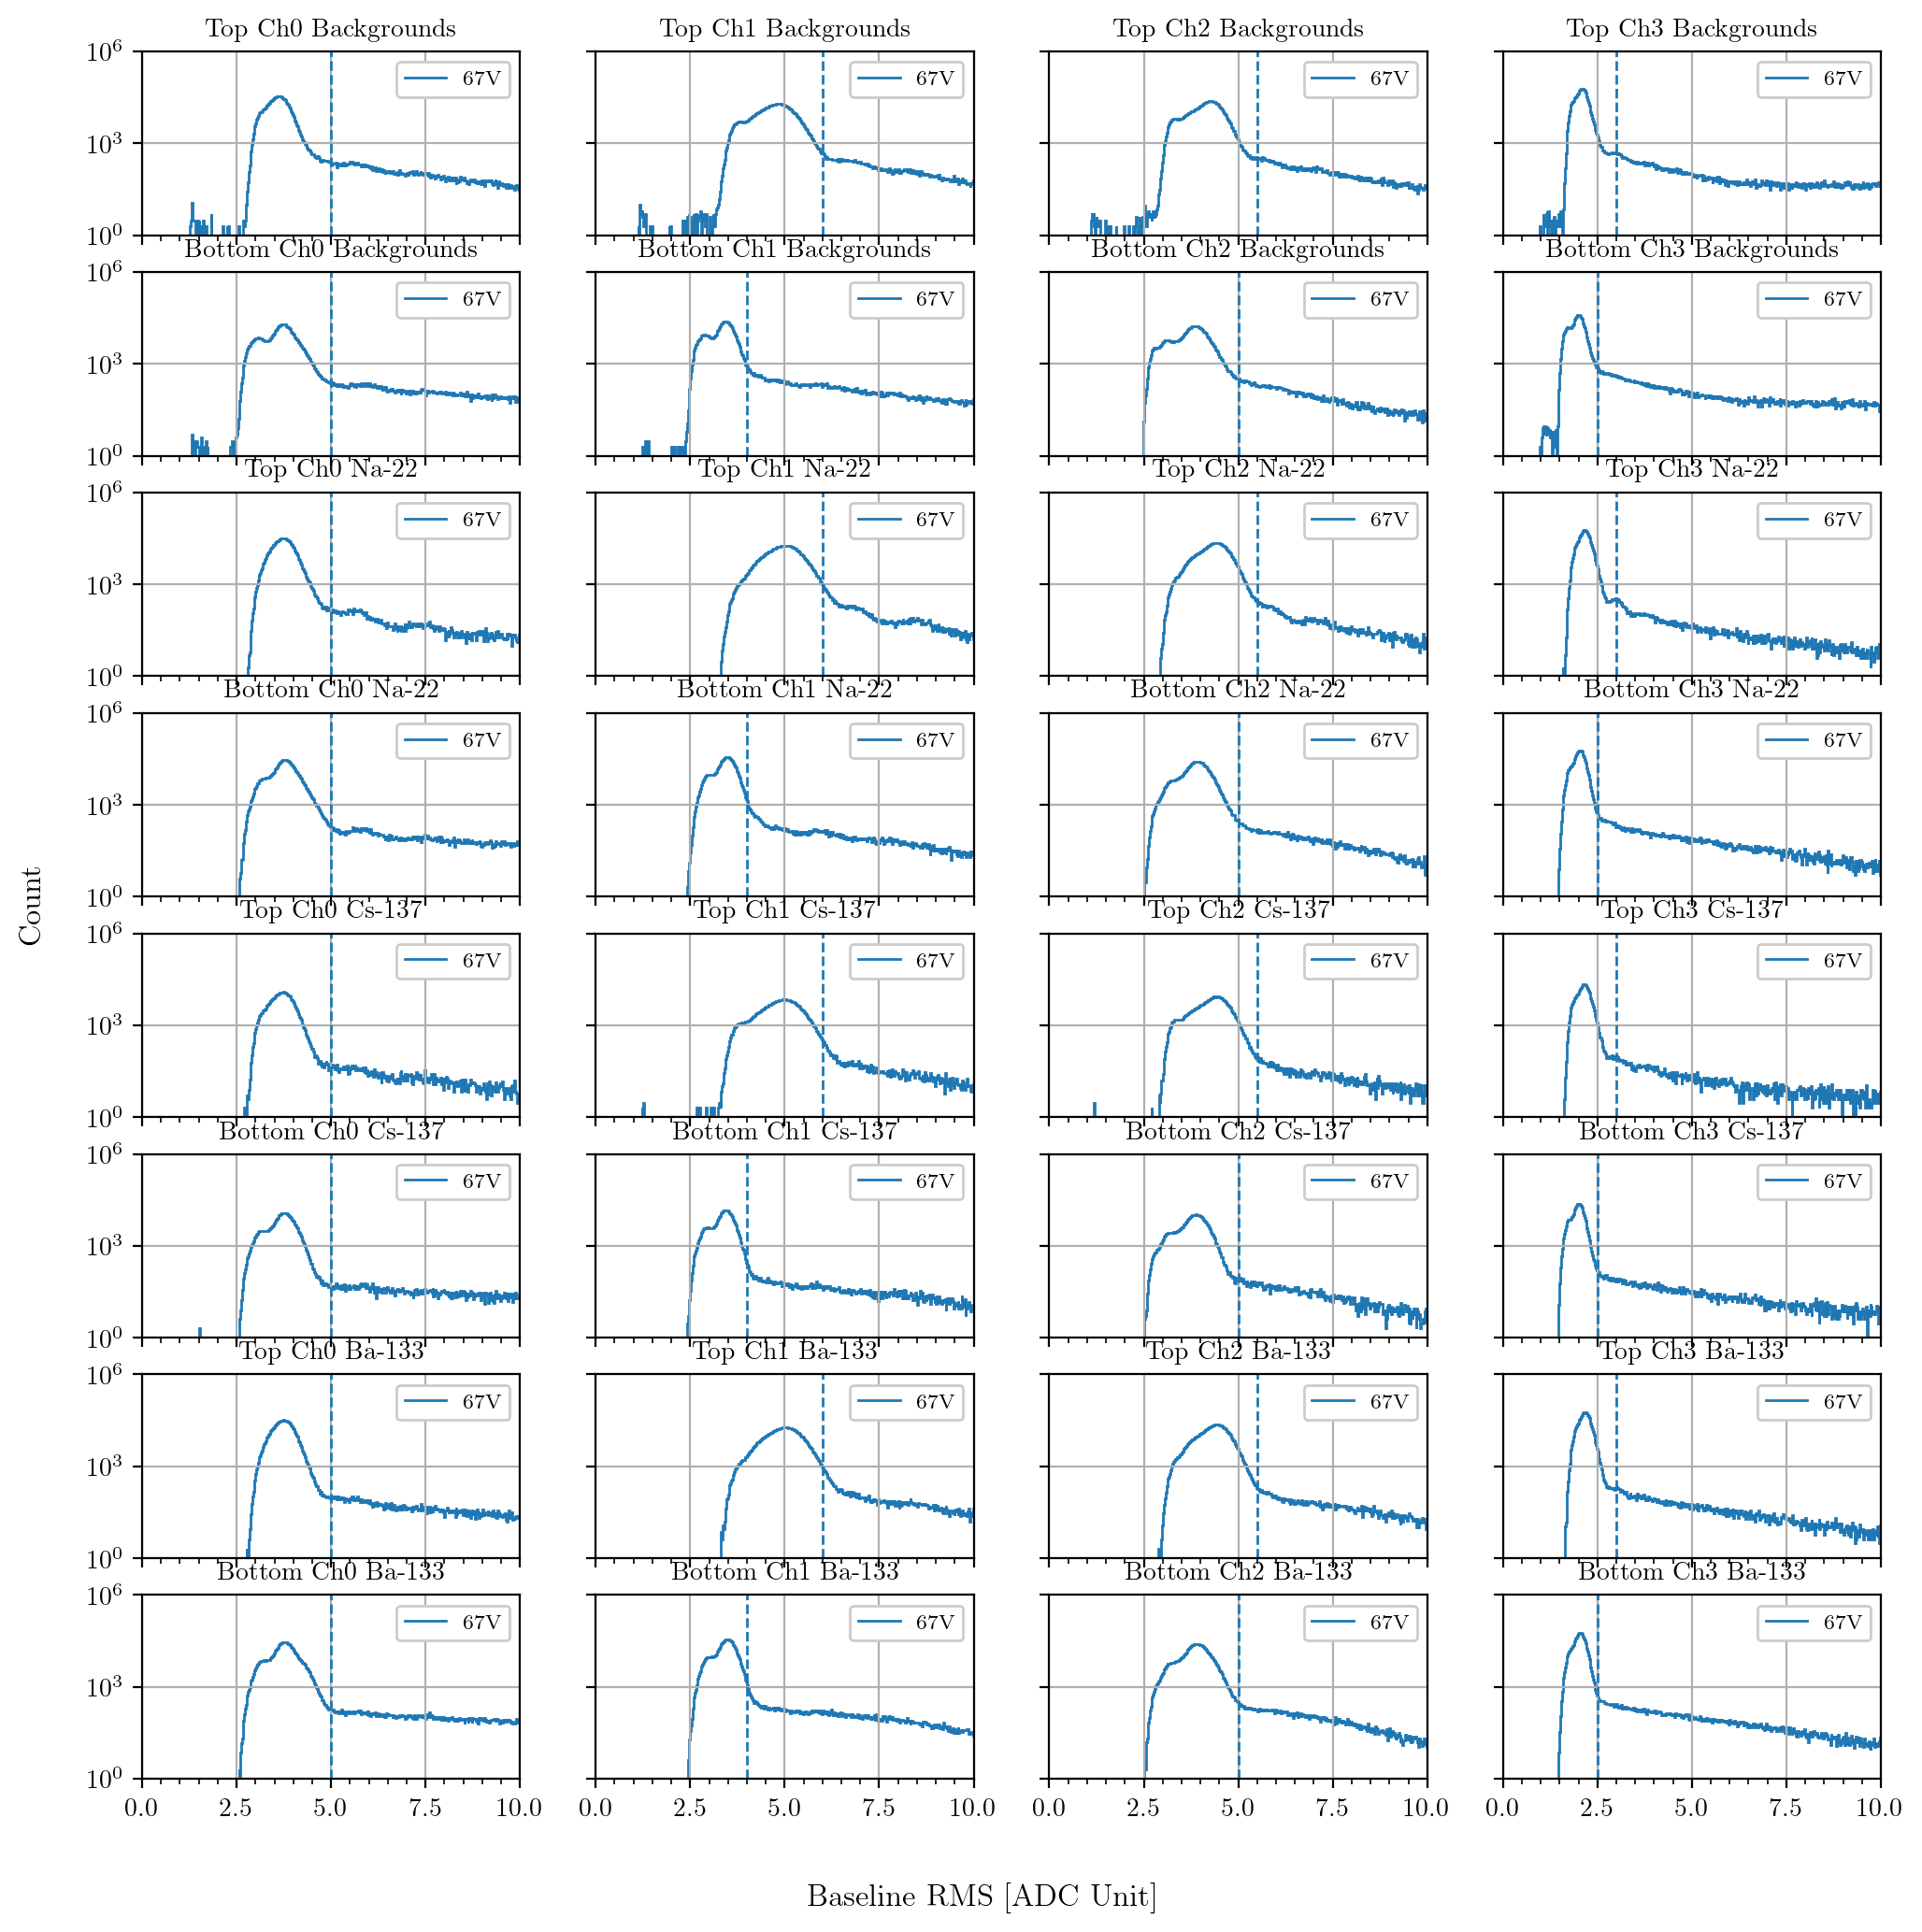

In [9]:
# Make plots for all datasets
# Baseline RMS
fig, axs = plt.subplots(8, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 12)
for i, c in enumerate(cond):
    for j, pos in enumerate(positions):
        for k, ch in enumerate(channels[1:]):
            for l, volt in enumerate(voltages):
                axs[i*2+j, k].stairs(
                    baseline[c][pos][ch][volt]['rms_counts'],
                    baseline[c][pos][ch][volt]['rms_bins'],
                    label=f'{volt}V', color=f'C{l}'
                )
                th = baseline[c][pos][ch][volt]['rms_threshold']
                axs[i*2+j, k].plot([th, th], [1, 1e6], f'C{l}--', linewidth=1)
            axs[i*2+j, k].legend(loc='upper right')
            axs[i*2+j, k].set_ylim(1, 1e6)
            axs[i*2+j, k].set_yscale('log')
            axs[i*2+j, k].minorticks_on()
            axs[i*2+j, k].grid()
            axs[i*2+j, k].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch} {c[0].upper()}{c[1:]}')
fig.supxlabel('Baseline RMS [ADC Unit]', y=0.05)
fig.supylabel('Count', x=0.07)

Text(0.07, 0.5, 'Count')

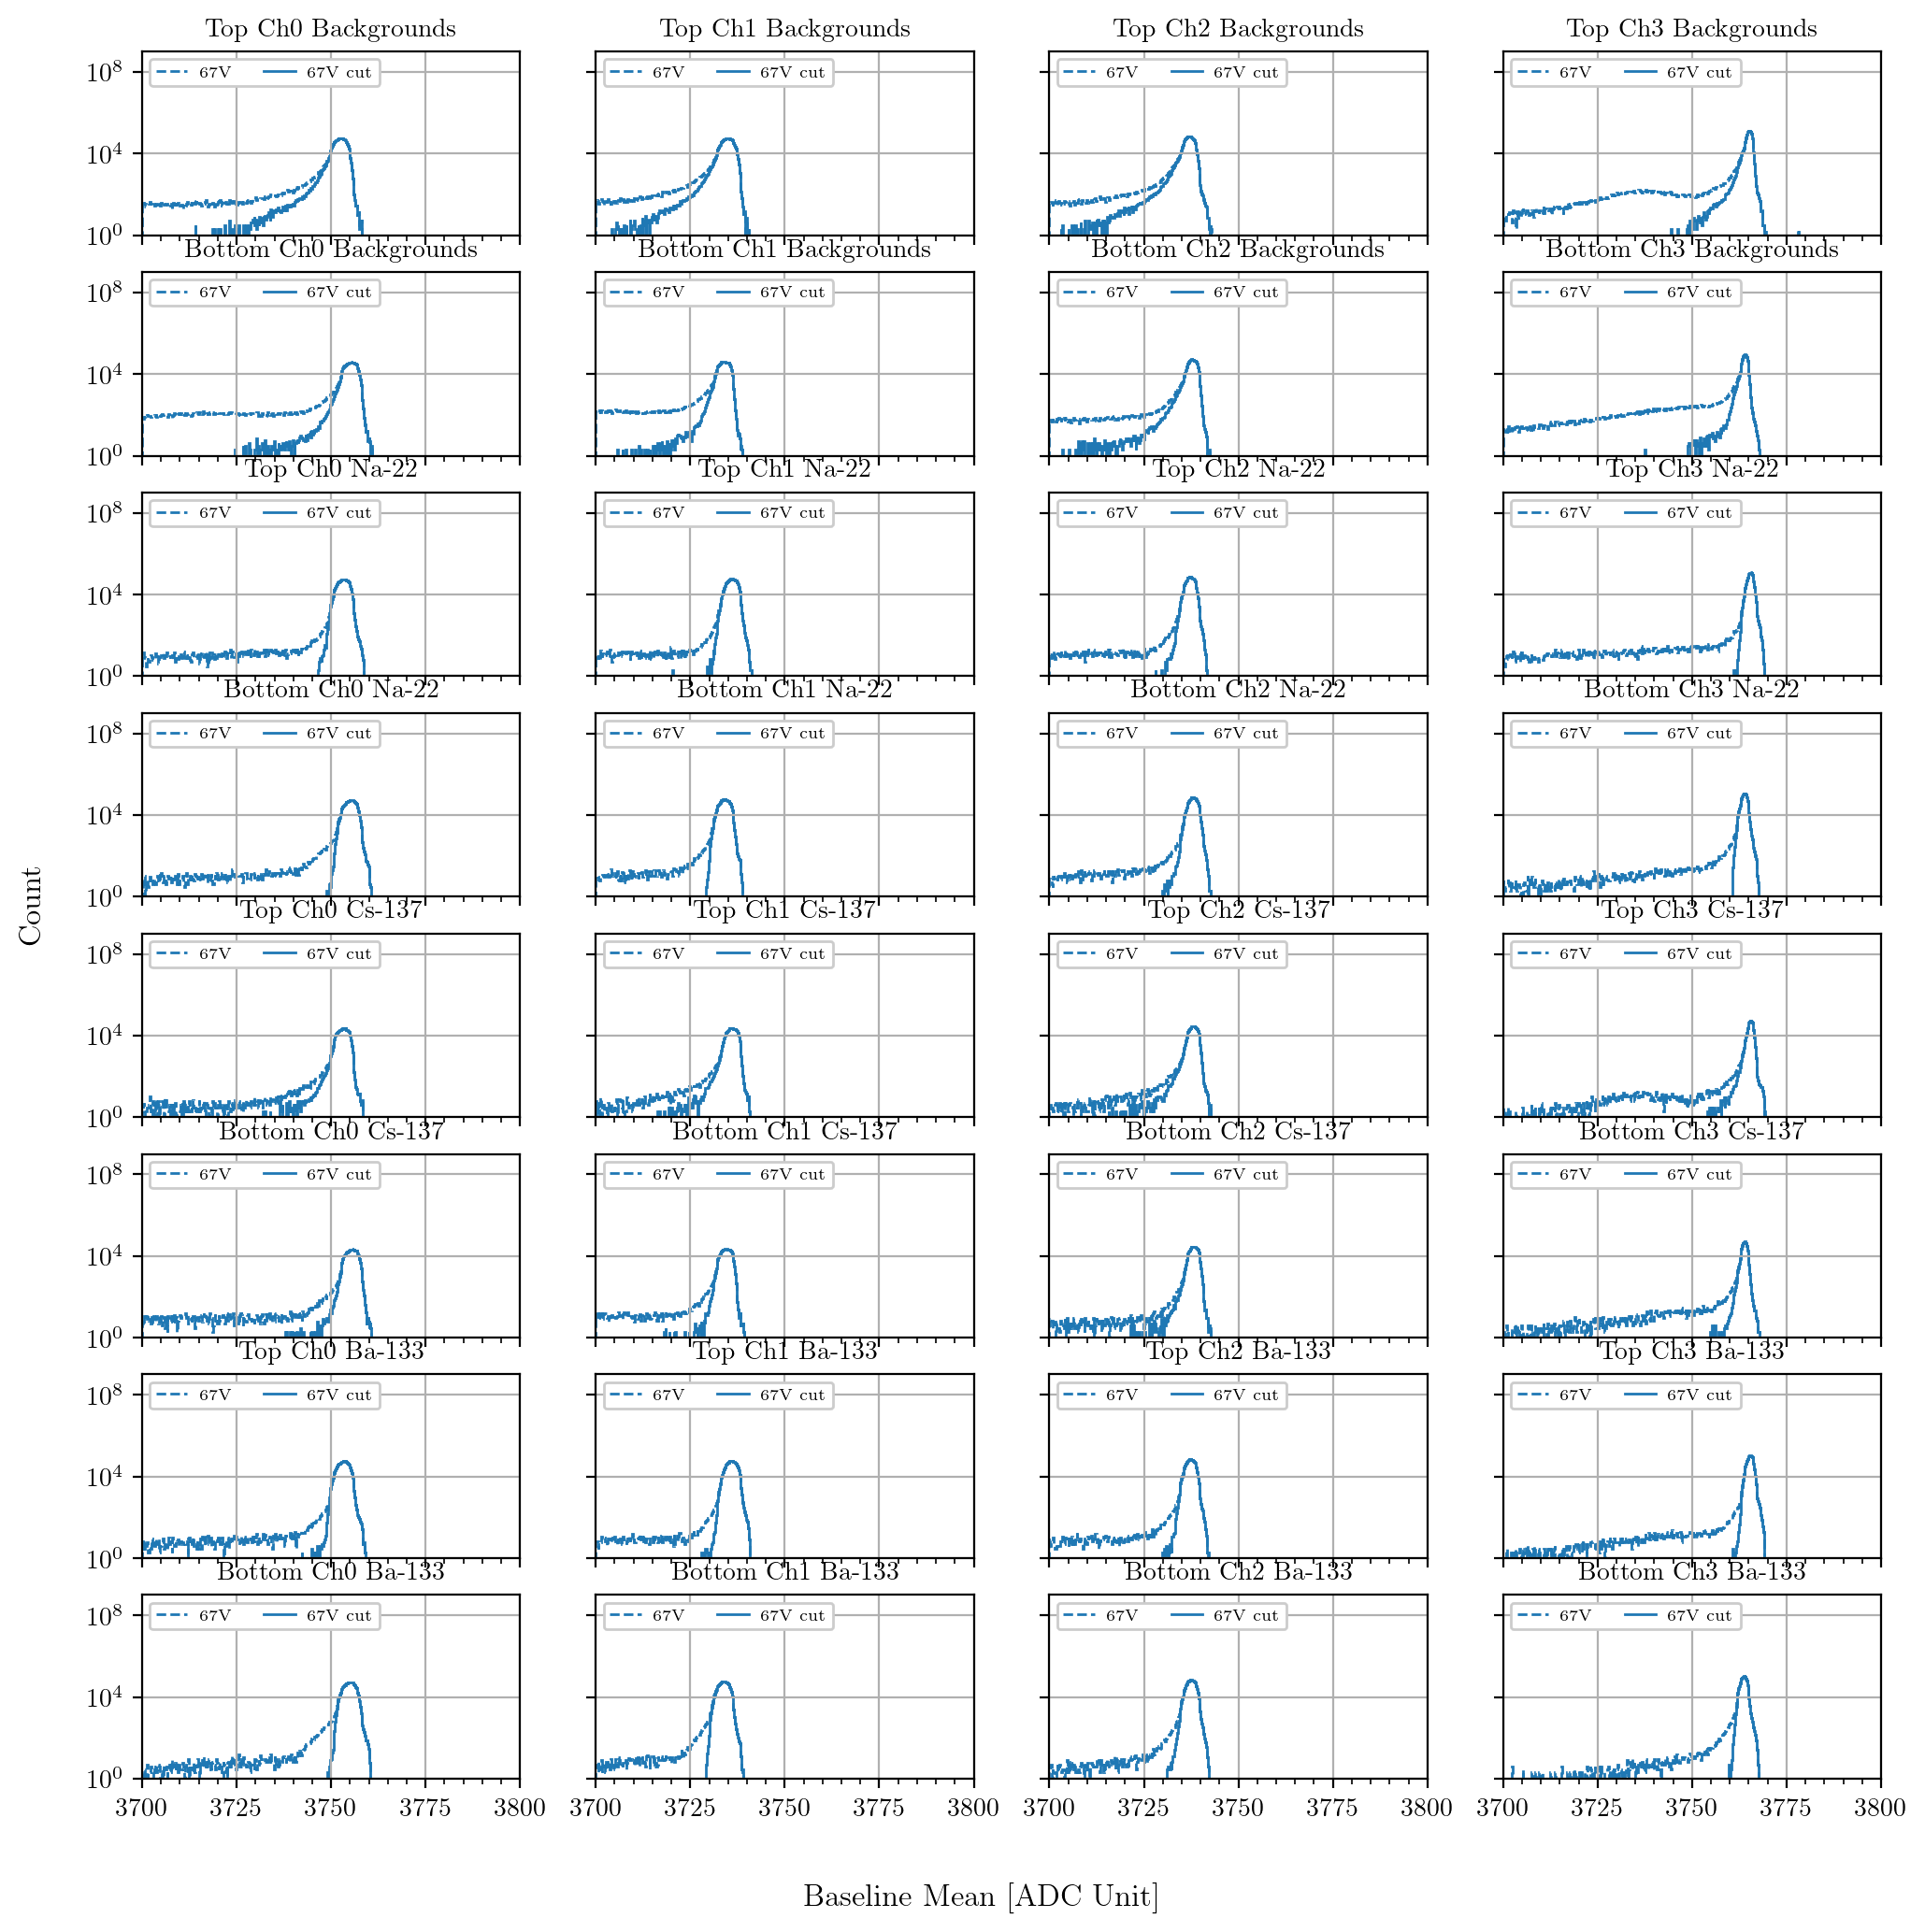

In [10]:
# Make plots for all datasets
# Baseline mean
fig, axs = plt.subplots(8, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 12)
for i, c in enumerate(cond):
    for j, pos in enumerate(positions):
        for k, ch in enumerate(channels[1:]):
            for l, volt in enumerate(voltages):
                axs[i*2+j, k].stairs(
                    baseline[c][pos][ch][volt]['mean_counts'],
                    baseline[c][pos][ch][volt]['mean_bins'],
                    label=f'{volt}V', color=f'C{l}', linestyle='--'
                )
                axs[i*2+j, k].stairs(
                    baseline[c][pos][ch][volt]['mean_counts_cut'],
                    baseline[c][pos][ch][volt]['mean_bins_cut'],
                    label=f'{volt}V cut', color=f'C{l}'
                )
            axs[i*2+j, k].legend(loc='upper left',ncol=2, fontsize=6)
            axs[i*2+j, k].set_ylim(1, 1e9)
            axs[i*2+j, k].set_yscale('log')
            axs[i*2+j, k].minorticks_on()
            axs[i*2+j, k].grid()
            axs[i*2+j, k].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch} {c[0].upper()}{c[1:]}')
fig.supxlabel('Baseline Mean [ADC Unit]', y=0.05)
fig.supylabel('Count', x=0.07)

Plots for top ch0 67V Backgrounds


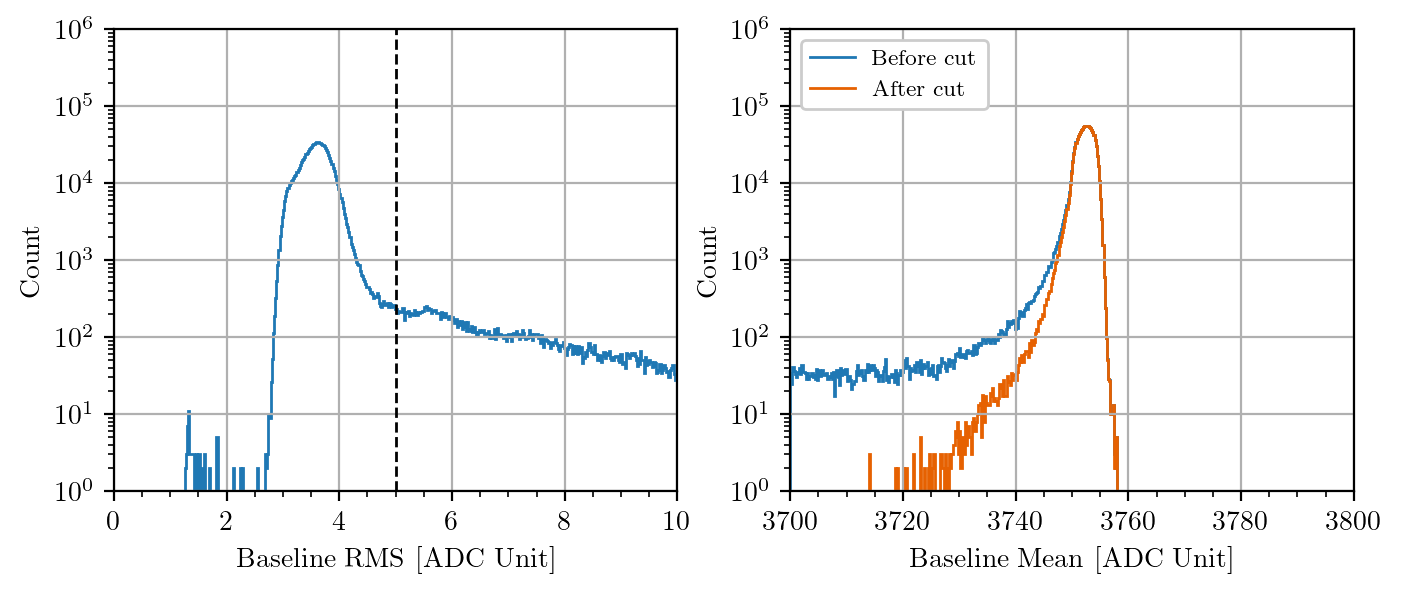

In [11]:
# Make plots for selected dataset
c = cond[0]
pos = positions[0]
ch = 0
volt = 67
print(f'Plots for {pos} ch{ch} {volt}V {c}')
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3)

# rms
axs[0].stairs(baseline[c][pos][ch][volt]['rms_counts'],
              baseline[c][pos][ch][volt]['rms_bins'])
th = baseline[c][pos][ch][volt]['rms_threshold']
axs[0].plot([th, th], [1, 1e6], 'k--', linewidth=1)
axs[0].set_ylim(1, 1e6)
axs[0].set_yscale('log')
axs[0].set_xlabel('Baseline RMS [ADC Unit]')
axs[0].set_ylabel('Count')
axs[0].minorticks_on()
axs[0].grid()

# mean
axs[1].stairs(baseline[c][pos][ch][volt]['mean_counts'],
              baseline[c][pos][ch][volt]['mean_bins'],
              label='Before cut')
axs[1].stairs(baseline[c][pos][ch][volt]['mean_counts_cut'],
              baseline[c][pos][ch][volt]['mean_bins_cut'],
              label='After cut')
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_ylim(1, 1e6)
axs[1].set_xlim(3700, 3800)
axs[1].set_xlabel('Baseline Mean [ADC Unit]')
axs[1].set_ylabel('Count')
axs[1].minorticks_on()
axs[1].grid()

## Fprompt cut
$F_{\rm prompt}$ is defined as the prompt ($0.5~\rm \mu s$) integral divided by the full ($5~\rm \mu s$) integral.
The ER band of $F_{\rm prompt}\sim0.3$ is clearly visible.
Yet some events have $F_{\rm prompt}\simeq0$, likely due to events triggered on noise with a delayed scintillation pulse.
These are rejected by requiring $F_{\rm prompt}>0.1$.

In [12]:
# Initialize container
fprompt = {}
for c in cond:
    fprompt[c] = {}
    for pos in positions:
        fprompt[c][pos] = {}
        for volt in voltages:
            fprompt[c][pos][volt] = {}

In [13]:
# Produce fprompt 2D histograms
nbinsx = 600
range_minx = -10
range_maxx = 3000
nbinsy = 600
range_miny = -0.1
range_maxy = 1

for c in cond:
    for pos in positions:
        for volt in voltages:
            fprompt[c][pos][volt]['fp_counts'], fprompt[c][pos][volt]['fp_xbins'], fprompt[c][pos][volt]['fp_ybins'] = np.histogram2d(
                data_aggr_bslcut[c][pos][volt]['total_pe'], 
                data_aggr_bslcut[c][pos][volt]['fprompt'], 
                bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
            )
            fprompt[c][pos][volt]['fp_counts'] = fprompt[c][pos][volt]['fp_counts'].T
            fprompt[c][pos][volt]['fp_xbins'], fprompt[c][pos][volt]['fp_ybins'] = np.meshgrid(
                fprompt[c][pos][volt]['fp_xbins'], fprompt[c][pos][volt]['fp_ybins']
            )
            fprompt[c][pos][volt]['fp_threshold'] = 0.1

Text(0.07, 0.5, '$F_{\\rm prompt}$')

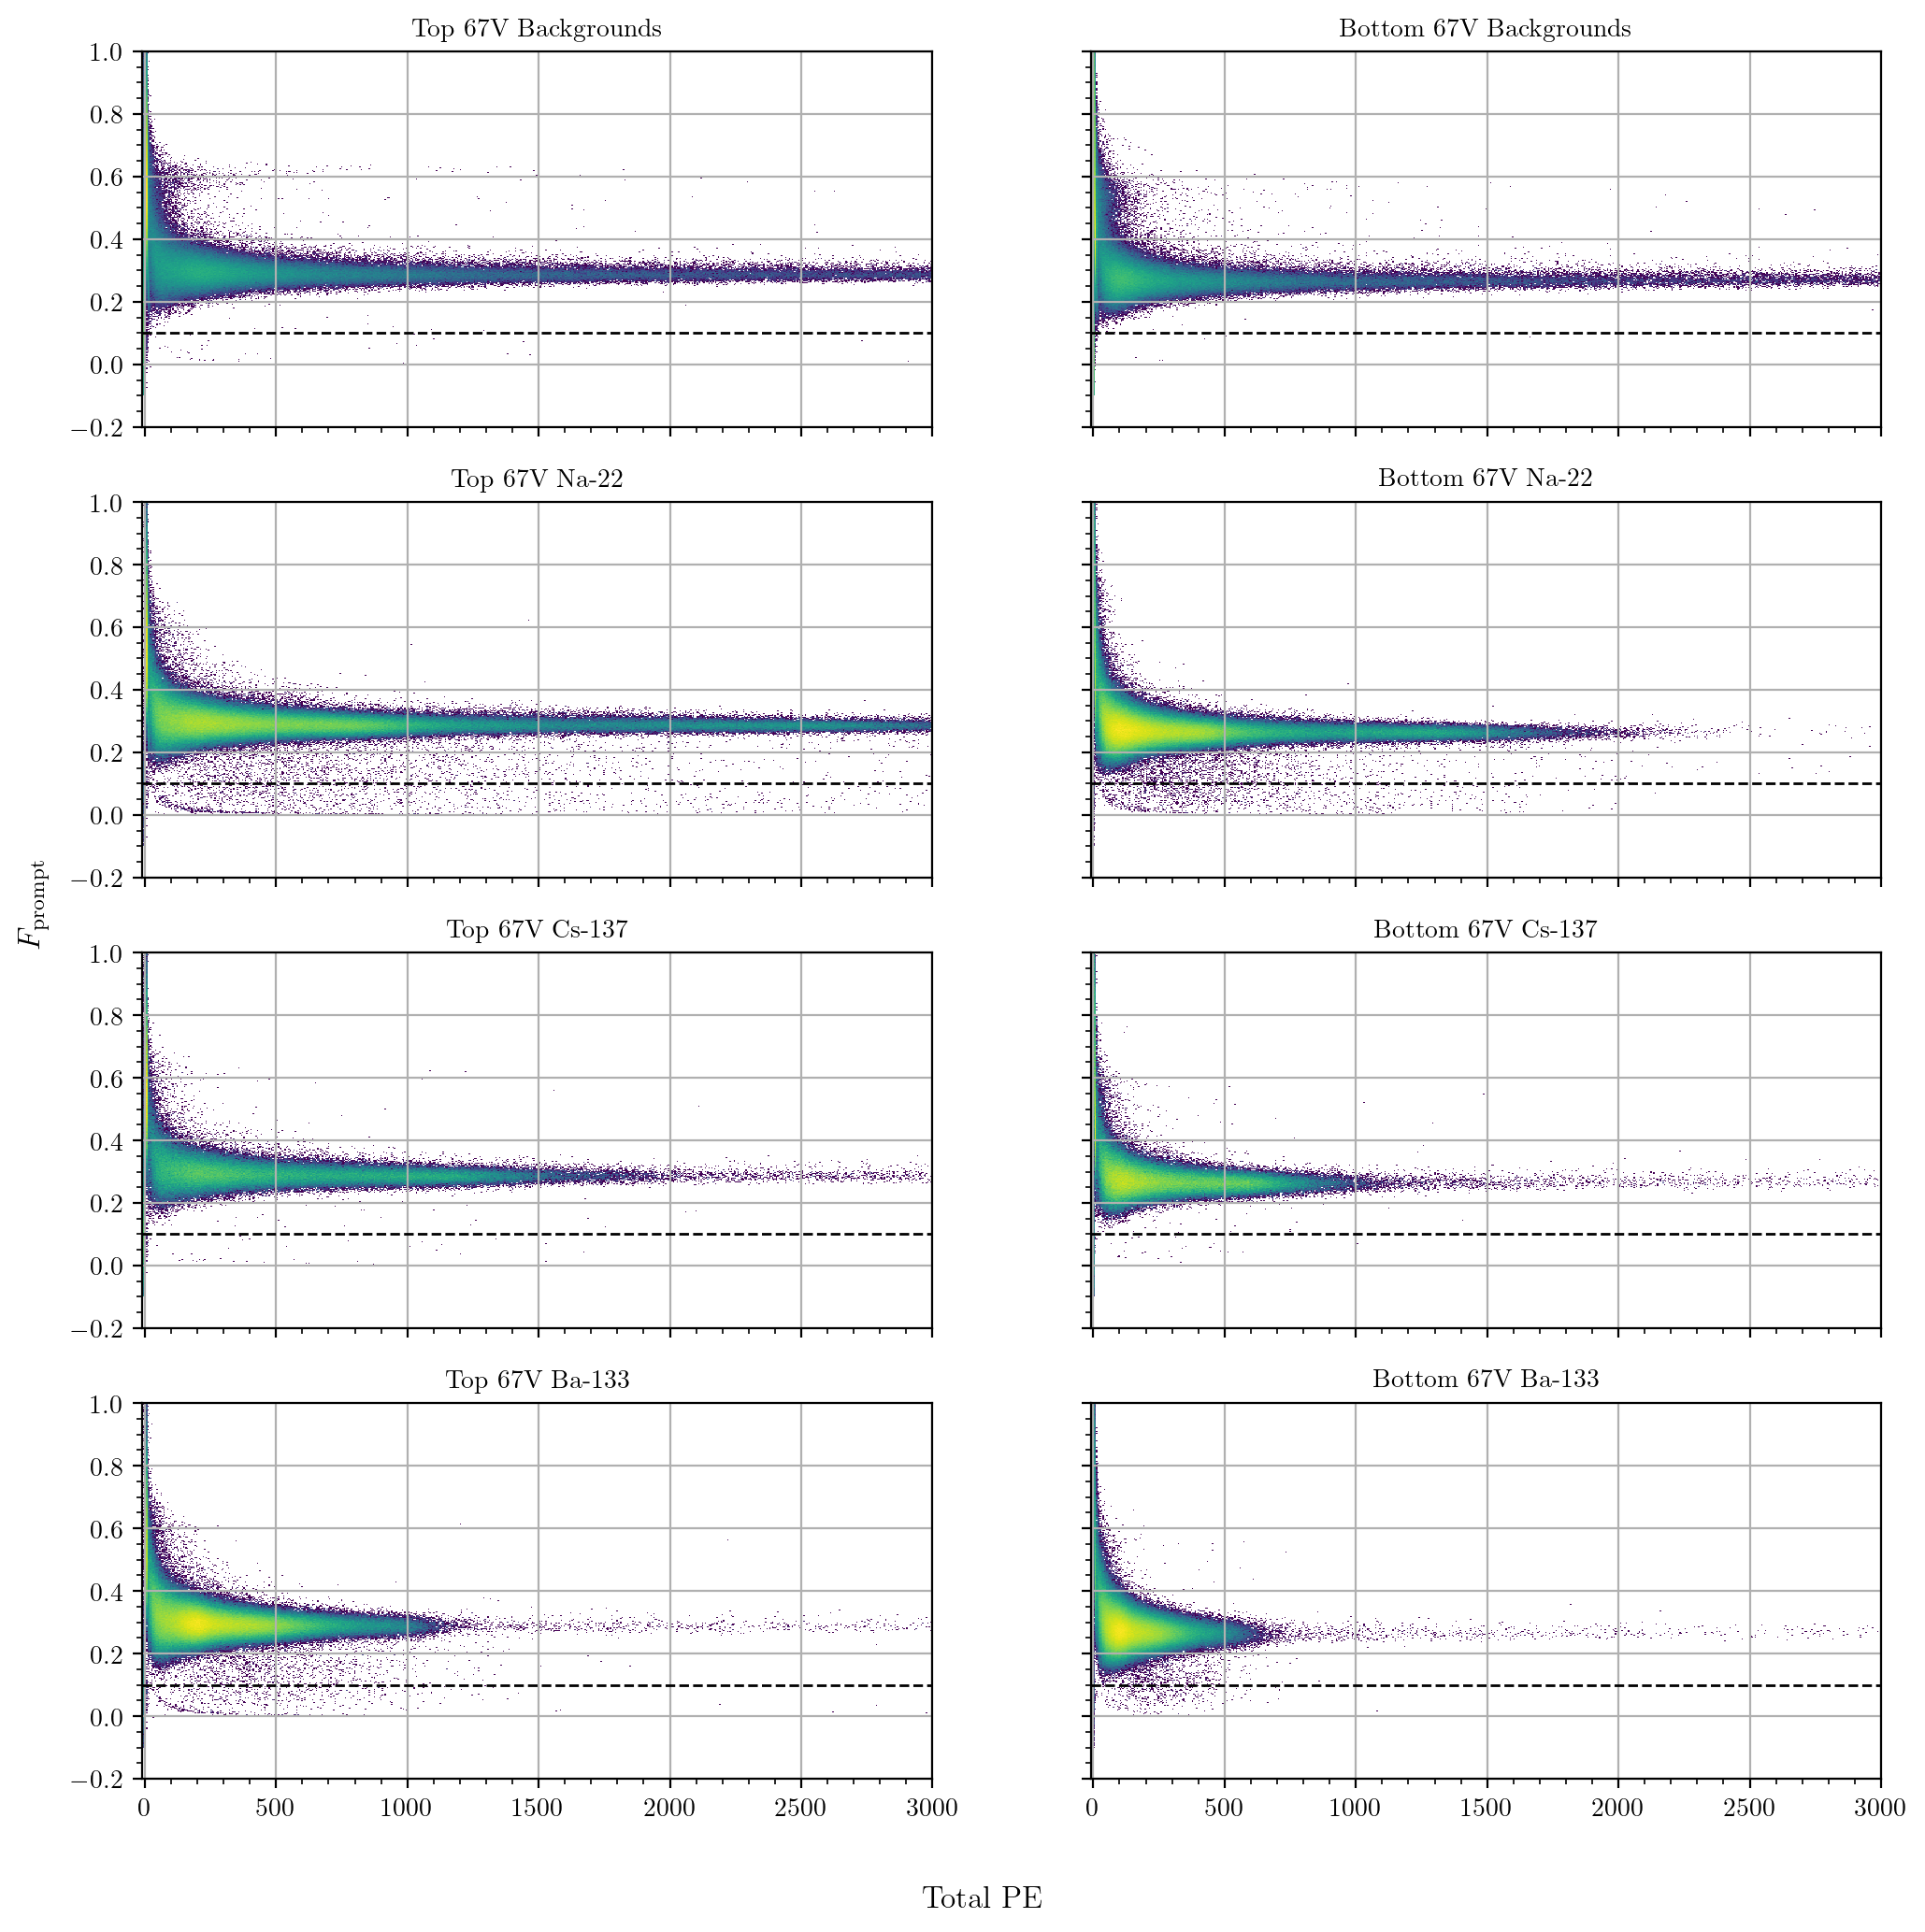

In [14]:
# Make plots for all datasets
# Fprompt
fig, axs = plt.subplots(4, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 12)
for i, c in enumerate(cond):
    for j, pos in enumerate(positions):
        axs[i, j].pcolormesh(
            fprompt[c][pos][volt]['fp_xbins'],
            fprompt[c][pos][volt]['fp_ybins'],
            np.log10(fprompt[c][pos][volt]['fp_counts'])
        )
        th = fprompt[c][pos][volt]['fp_threshold']
        axs[i, j].plot([-10, range_maxx], [th, th], f'k--', linewidth=1)
        axs[i, j].set_xlim(-10, range_maxx)
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} {voltages[0]}V {c[0].upper()}{c[1:]}')
fig.supxlabel('Total PE', y=0.05)
fig.supylabel(r'$F_{\rm prompt}$', x=0.07)

Plots for top ch0 67V Backgrounds


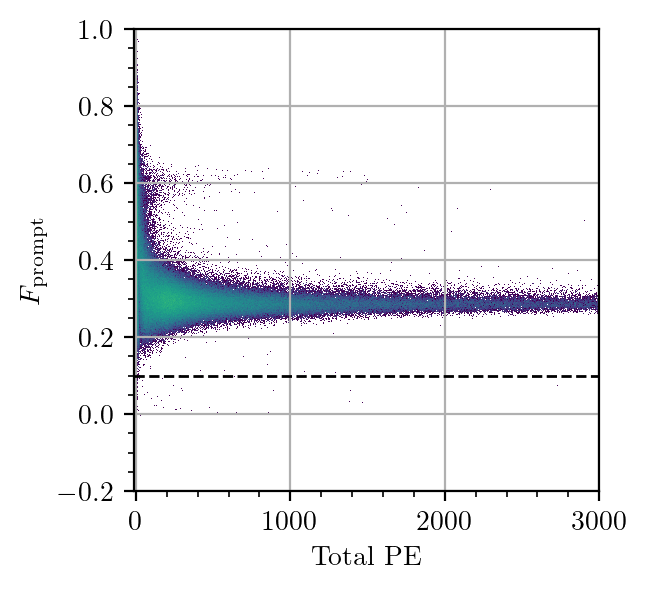

In [15]:
# Make plots for selected dataset
c = cond[0]
pos = positions[0]
ch = 0
volt = 67
print(f'Plots for {pos} ch{ch} {volt}V {c}')
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(3, 3)

# Fprompt
axs.pcolormesh(fprompt[c][pos][volt]['fp_xbins'],fprompt[c][pos][volt]['fp_ybins'],np.log10(fprompt[c][pos][volt]['fp_counts']))
th = fprompt[c][pos][volt]['fp_threshold']
axs.plot([-10, range_maxx], [th, th], f'k--', linewidth=1)
axs.set_xlim(-10, range_maxx)
axs.set_xlabel('Total PE')
axs.set_ylabel(r'$F_{\rm prompt}$')
axs.minorticks_on()
axs.grid()

In [16]:
# Calculate cut fraction: fprompt>0.1
data_aggr_allcuts = {}
for c in cond:
    data_aggr_allcuts[c] = {}
    for pos in positions:
        data_aggr_allcuts[c][pos] = {}
        for volt in voltages:  
            data_aggr_allcuts[c][pos][volt] = data_aggr_bslcut[c][pos][volt].loc[ 
                data_aggr_bslcut[c][pos][volt]['fprompt']>fprompt[c][pos][volt]['fp_threshold'] 
            ]
            cut_fraction = 1-data_aggr_allcuts[c][pos][volt].shape[0]/data_aggr_bslcut[c][pos][volt].shape[0]
            fprompt[c][pos][volt]['cut_fraction'] = cut_fraction
            print(f'{pos} {volt}V {c} cut fraction = {cut_fraction*100:.5f}%')
# clear memory
data_aggr_bslcut = None

top 67V Backgrounds cut fraction = 5.42735%
bottom 67V Backgrounds cut fraction = 5.52619%
top 67V Na-22 cut fraction = 0.84215%
bottom 67V Na-22 cut fraction = 0.35033%
top 67V Cs-137 cut fraction = 3.27203%
bottom 67V Cs-137 cut fraction = 0.95119%
top 67V Ba-133 cut fraction = 0.70651%
bottom 67V Ba-133 cut fraction = 0.25268%


In [17]:
# Print container keys
print('fprompt keys: ', list(
    fprompt[cond[0]][positions[0]][voltages[0]].keys()))
print('data_aggr_allcuts keys: ', list(
    data_aggr_allcuts[cond[0]][positions[0]][voltages[0]].keys()))

fprompt keys:  ['fp_counts', 'fp_xbins', 'fp_ybins', 'fp_threshold', 'cut_fraction']
data_aggr_allcuts keys:  ['total_pe', 'fprompt', 'baseline_rms0', 'baseline_rms1', 'baseline_rms2', 'baseline_rms3']


## Draw spectra
The PE count $N_{\rm PE}$ is reconstructed as
$$N_{\rm PE}=\frac{I}{Q_{\rm peak}(1+Q_{\rm AP})/(1-p)}$$
where $I$ is the time integral ($5~\rm\mu s$) of the unfiltered waveform.
Ideally, this corrects for the direct crosstalk and afterpulsing effects of increasing light yield.

The spectra with source are subtracted by that without source (backgrounds only).
The spectra are normalized with the background sideband ($N_{\rm PE}>170$ for top and $N_{\rm PE}>900$ for bottom).

In [18]:
# Initialize container
spectra = {}
types = cond + [c+' (subtracted)' for c in cond[1:]]
for t in types:
    spectra[t] = {}
    for pos in positions:
        spectra[t][pos] = {}
        for volt in voltages:
            spectra[t][pos][volt] = {}

## Note: divide total_pe by gain=2.0 here

In [19]:
# Region above norm_bounds is background only. Use event count in this region to normalize spectrum.
norm_bounds = {'top':[2500],'bottom':[2000]}
for t in types[:-3]:
    for pos in positions:
        for i,volt in enumerate(voltages):
            if pos=='top':
                range_min = 0
                range_max = 4000
                nbins = 2000
            elif pos=='bottom':
                range_min = 0
                range_max = 4000
                nbins = 2000
            spectra[t][pos][volt]['norm_bound'] = norm_bounds[pos][i]
            spectra[t][pos][volt]['counts'], spectra[t][pos][volt]['bins'] = np.histogram(
                data_aggr_allcuts[t][pos][volt]['total_pe']/gain, 
                bins=nbins, range=(range_min, range_max)
            )
            spectra[t][pos][volt]['errs'] = np.sqrt(spectra[t][pos][volt]['counts'])
            # normalization
            spectra[t][pos][volt]['norm'] = np.sum(
                spectra[t][pos][volt]['counts'][
                    spectra[t][pos][volt]['bins'][:-1]>spectra[t][pos][volt]['norm_bound']
                ]
            )

for i,t in enumerate(types[-3:]):
    for pos in positions:
        for volt in voltages:
            spectra[t][pos][volt]['bins'] = np.copy(spectra[types[0]][pos][volt]['bins'])
            spectra[t][pos][volt]['norm_bound'] = spectra[types[0]][pos][volt]['norm_bound']
            spectra[t][pos][volt]['norm'] = 1
            spectra[t][pos][volt]['counts'] = spectra[types[i+1]][pos][volt]['counts']/spectra[types[i+1]][pos][volt]['norm'] - spectra[types[0]][pos][volt]['counts']/spectra[types[0]][pos][volt]['norm']
            spectra[t][pos][volt]['errs'] = ((spectra[types[i+1]][pos][volt]['errs']/spectra[types[i+1]][pos][volt]['norm'])**2 + (spectra[types[0]][pos][volt]['errs']/spectra[types[0]][pos][volt]['norm'])**2)**0.5

# 5/12 Na-22/Cs-137/Ba-133 Data

Text(0.07, 0.5, 'Count')

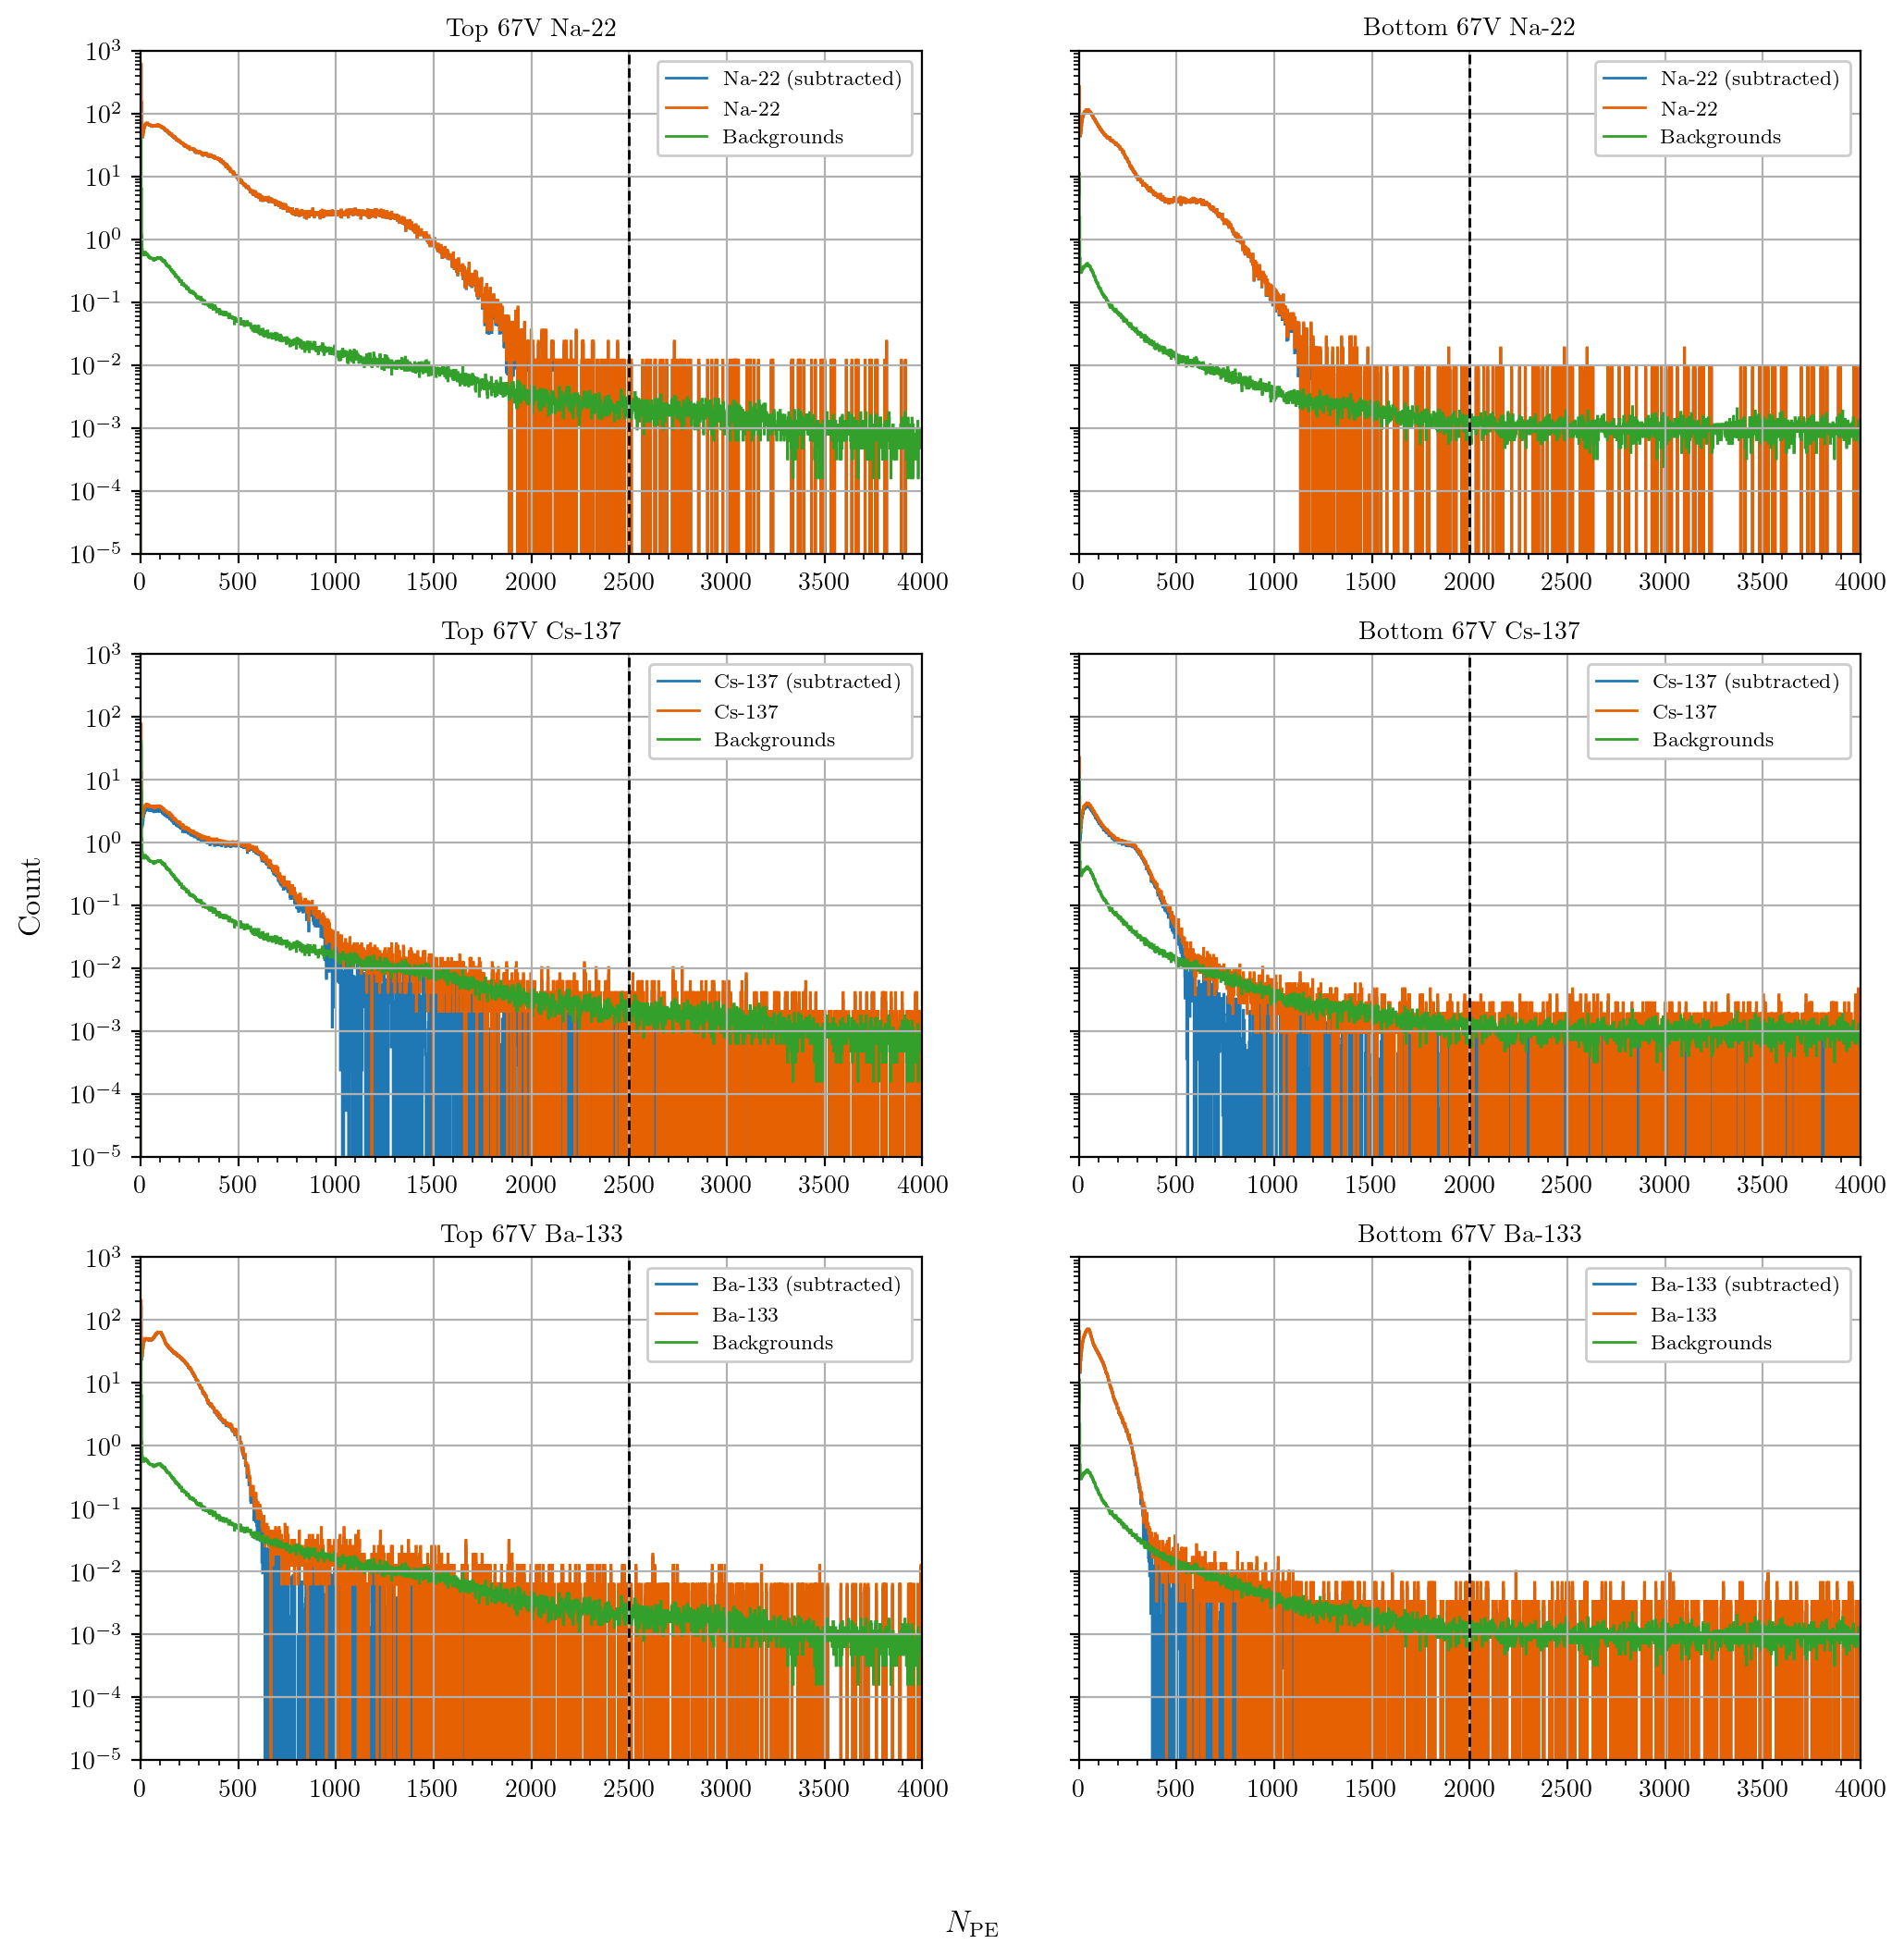

In [20]:
# Make plots for all datasets
# With source, without source, and background subtracted
fig, axs = plt.subplots(3, 2, sharex=False, sharey=True)
fig.set_size_inches(12, 12)
for i, pos in enumerate(positions):
    for j, volt in enumerate(voltages):
        for k, t in enumerate(types[-3:]):
            axs[k, i].stairs(
                spectra[t][pos][volt]['counts']/spectra[t][pos][volt]['norm'],
                spectra[t][pos][volt]['bins'],
                label=f'{t}', color=f'C0'
            )
            axs[k, i].stairs(
                spectra[types[k+1]][pos][volt]['counts']/spectra[types[k+1]][pos][volt]['norm'],
                spectra[types[k+1]][pos][volt]['bins'],
                label=f'{types[k+1]}', color=f'C1'
            )
            axs[k, i].stairs(
                spectra[types[0]][pos][volt]['counts']/spectra[types[0]][pos][volt]['norm'],
                spectra[types[0]][pos][volt]['bins'],
                label=f'{types[0]}', color=f'C2'
            )
            th = spectra[cond[0]][pos][volt]['norm_bound']
            axs[k, i].plot([th, th], [1e-5, 1e3], f'k--', linewidth=1)
            axs[k, i].legend(loc='upper right')
            axs[k, i].set_ylim(1e-5, 1e3)
            axs[k, i].set_xlim(spectra[t][pos][volt]['bins'][0],spectra[t][pos][volt]['bins'][-1])
            axs[k, i].set_yscale('log')
            axs[k, i].minorticks_on()
            axs[k, i].grid()
            axs[k, i].set_title(f'{pos[0].upper()}{pos[1:]} {volt}V {types[k+1]}')
fig.supxlabel(r'$N_{\rm PE}$', y=0.03)
fig.supylabel('Count', x=0.07)

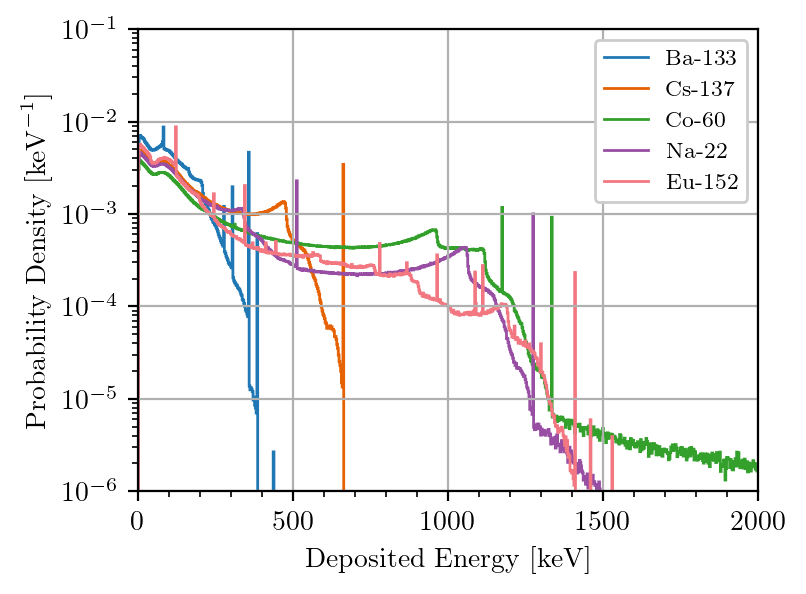

In [21]:
dir_gamma = 'data/gamma/'
files_gamma = ['spectrum_ba133_ene.root','spectrum_cs137_ene.root','spectrum_co60_ene.root','spectrum_na22_ene.root','spectrum_eu152_ene.root']
gammas = ['Ba-133','Cs-137','Co-60','Na-22','Eu-152']
for f,g in zip(files_gamma,gammas):
    root_file = ROOT.TFile.Open(f"{dir_gamma}{f}", "read")
    root_hist = root_file.Get("hEne")
    bins_ene =[]
    rates_ene = []
    for i in range(1,root_hist.GetNbinsX()+1):
        bins_ene.append(root_hist.GetBinLowEdge(i))
        rates_ene.append(root_hist.GetBinContent(i))
    bins_ene.append(bins_ene[-1]+root_hist.GetBinWidth(1))
    bins_ene = np.array(bins_ene)
    rates_ene = np.array(rates_ene)
    rates_ene /= np.sum(rates_ene)*root_hist.GetBinWidth(1)
    plt.stairs(rates_ene, bins_ene,label=g)
plt.legend(loc='upper right')
plt.yscale('log')
plt.ylabel(r'Probability Density [$\rm{keV}^{-1}$]')
plt.ylim(1e-6,1e-1)
plt.xlim(0,2000)
plt.xlabel('Deposited Energy [keV]')
plt.grid()
plt.minorticks_on()

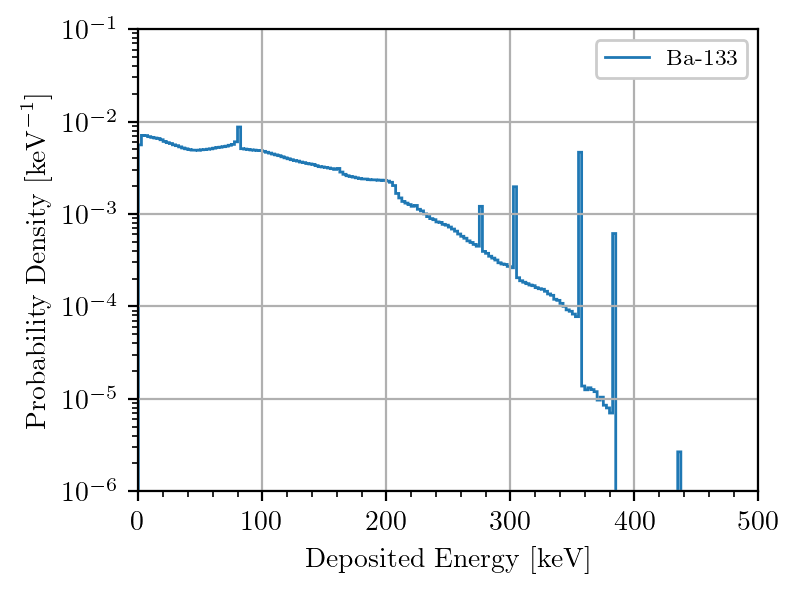

In [6]:
dir_gamma = 'data/gamma/'
files_gamma = ['spectrum_ba133_ene.root']
gammas = ['Ba-133']
for f,g in zip(files_gamma,gammas):
    root_file = ROOT.TFile.Open(f"{dir_gamma}{f}", "read")
    root_hist = root_file.Get("hEne")
    bins_ene =[]
    rates_ene = []
    for i in range(1,root_hist.GetNbinsX()+1):
        bins_ene.append(root_hist.GetBinLowEdge(i))
        rates_ene.append(root_hist.GetBinContent(i))
    bins_ene.append(bins_ene[-1]+root_hist.GetBinWidth(1))
    bins_ene = np.array(bins_ene)
    rates_ene = np.array(rates_ene)
    rates_ene /= np.sum(rates_ene)*root_hist.GetBinWidth(1)
    plt.stairs(rates_ene, bins_ene,label=g)
plt.legend(loc='upper right')
plt.yscale('log')
plt.ylabel(r'Probability Density [$\rm{keV}^{-1}$]')
plt.ylim(1e-6,1e-1)
plt.xlim(0,500)
plt.xlabel('Deposited Energy [keV]')
plt.grid()
plt.minorticks_on()

## Detector response model
Consider light yield non-uniformity. Let $\alpha$ be the relative RMS variation:
$$L'_y \sim \mathcal{N}(\mu = L_y, \sigma=\alpha L_y)$$
Fix Fano factor to $1+p$ derived from compound Poisson distribution. The $(1-p)^2$ factor is canceled out due to the DiCT correction in PE reconstruction.
This Fano factor accounts for photon transport and direct crosstalk effects.
$$N_{\rm PE} \sim \mathcal{N}(\mu=L'_y E_{\rm dep}, \sigma=\sqrt{(1+p)L'_y E_{\rm dep}})$$

In [7]:
import scipy.integrate as intg 
from scipy.stats import norm
import math

class Spectrum():
    def __init__(self, dict, root_file_path="data/gamma/spectrum_cs137_ene.root", pe_max=1500, pe_width=5):
        self.pe_max = pe_max
        self.pe_width = pe_width
        self.root_file_path = root_file_path
        self.bins_ene =[]
        self.rates_ene = []
        self.dict = dict
        self.ly = 0
        self.alpha = 0
        self.read_energy_spectrum()
    
    def read_energy_spectrum(self):
        self.root_file = ROOT.TFile.Open(self.root_file_path, "read")
        root_hist = self.root_file.Get("hEne")
        for i in range(1,root_hist.GetNbinsX()+1):
            self.bins_ene.append(root_hist.GetBinLowEdge(i))
            self.rates_ene.append(root_hist.GetBinContent(i))
        self.bins_ene.append(self.bins_ene[-1]+root_hist.GetBinWidth(1))
        self.bins_ene = np.array(self.bins_ene)
        self.rates_ene = np.array(self.rates_ene)
        self.rates_ene /= np.sum(self.rates_ene) # normalize total count to 1

    def response_matrix(self, ene, pe, ly):
        return norm.pdf(pe, loc=ly*ene, scale=np.sqrt(ly*ene*(1+self.dict)))

    def get_pe_spectrum(self, ly, alpha):
        self.ly = ly
        self.alpha = alpha
        # self.bins_pe = self.bins_ene*ly
        self.bins_pe = np.arange(0,self.pe_max, self.pe_width)
        self.rates_pe = np.zeros(self.bins_pe.shape[0]-1)
        bincen_ene = (self.bins_ene[1:] + self.bins_ene[:-1])/2
        bincen_pe = (self.bins_pe[1:] + self.bins_pe[:-1])/2
        bincen_ly = np.linspace(max(ly*(1-3*alpha),0), ly*(1+5*alpha), 100)
        ene_mesh, pe_mesh, ly_mesh = np.meshgrid( bincen_ene, bincen_pe, bincen_ly)
        s_ly = norm.pdf(bincen_ly,loc=ly, scale=ly*alpha)
        self.rates_pe = np.dot(np.dot(self.response_matrix(ene_mesh, pe_mesh, ly_mesh),s_ly),self.rates_ene)
        self.rates_pe *= (bincen_ly[1]-bincen_ly[0])
        
    def pe_spectrum(self, pe, ly, alpha, n):
        if not math.isclose(ly, self.ly) or not math.isclose(alpha, self.alpha):
            self.get_pe_spectrum(ly, alpha)
        pe_id = (np.clip(pe/(self.bins_pe[1]-self.bins_pe[0]),0, self.bins_pe.shape[0]-2)).astype(int)
        return n*self.rates_pe[pe_id]

## Read DiCT probability from csv file

In [10]:
import csv
p_dict = {'top':{}, 'bottom':{}}
syserr2 = {'top':{}, 'bottom':{}}
for volt in voltages:
    p_dict['top'][volt] = 0
    p_dict['bottom'][volt] = 0
    syserr2['top'][volt] = 0
    syserr2['bottom'][volt] = 0
    with open('data/calibration_liq3/calibration_liq3_{}V.csv'.format(volt)) as f:
        r = csv.reader(f)
        line_count = 0
        for row in r:
            if line_count>0:
                if line_count<=4:
                    p_dict['top'][volt] += float(row[3])
                    syserr2['top'][volt] += (float(row[6])/float(row[5]))**2 + (float(row[4])/(1-float(row[3])))**2
                else:
                    p_dict['bottom'][volt] += float(row[3])
                    syserr2['bottom'][volt] += (float(row[6])/float(row[5]))**2 + (float(row[4])/(1-float(row[3])))**2
            line_count += 1
        p_dict['top'][volt] /= 4
        p_dict['bottom'][volt] /= 4
print('DiCT probability:')
print(p_dict)
print('Systematics from calibration:')
print(syserr2)

DiCT probability:
{'top': {67: 0.2231775581523925}, 'bottom': {67: 0.23773885259721}}
Systematics from calibration:
{'top': {67: 0.0002695501344011728}, 'bottom': {67: 0.0006942822270975785}}


Text(0.5, 0, '$N_{\\rm PE}$')

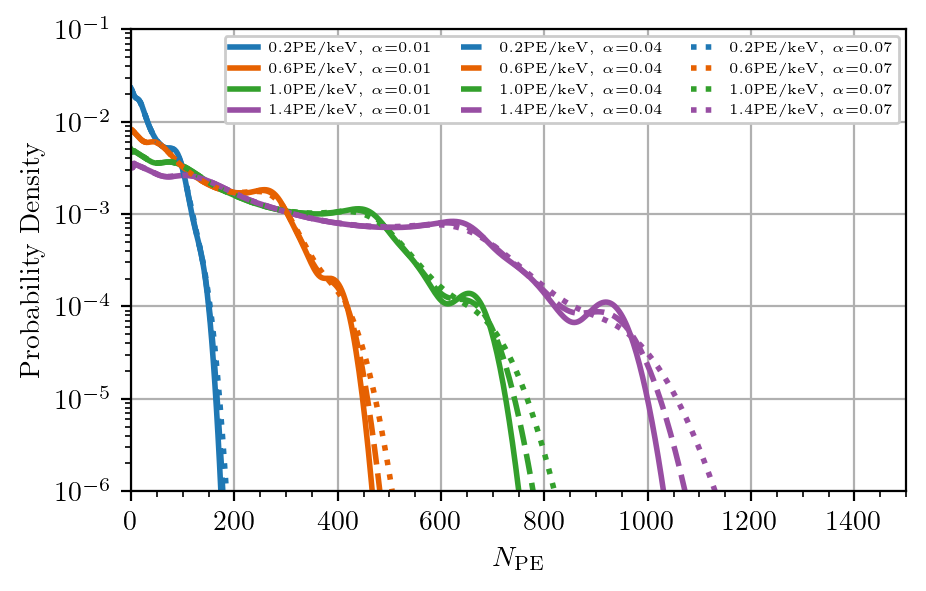

In [16]:
s = Spectrum(p_dict['top'][67], pe_max=1500, pe_width=3, root_file_path="data/gamma/spectrum_cs137_ene.root")
alphas = [0.01, 0.04, 0.07]
lys = [0.2, 0.6, 1.0, 1.4]
pe_arr = np.arange(0,1500,3)
styles = ['solid', 'dashed', 'dotted']
plt.figure(figsize=(5,3))
for i,a_ in enumerate(alphas):
    for j,l_ in enumerate(lys):
        s.get_pe_spectrum(l_, a_)
        pe_spectrum = s.pe_spectrum(pe_arr, l_, a_, 1.0)
        plt.plot(pe_arr, pe_spectrum,label=r'${}$PE/keV, $\alpha$={}'.format(l_,a_),color=f'C{j}',linestyle=styles[i])
plt.yscale('log')
plt.ylim(1e-6,1e-1)
plt.xlim(0,1500)
plt.grid()
plt.minorticks_on()
plt.legend(loc='upper right',ncol=3,prop={'size': 5})
plt.ylabel('Probability Density')
plt.xlabel(r'$N_{\rm PE}$')

# Compare with MC spectra + response model

Text(0.07, 0.5, 'Probability Density per PE')

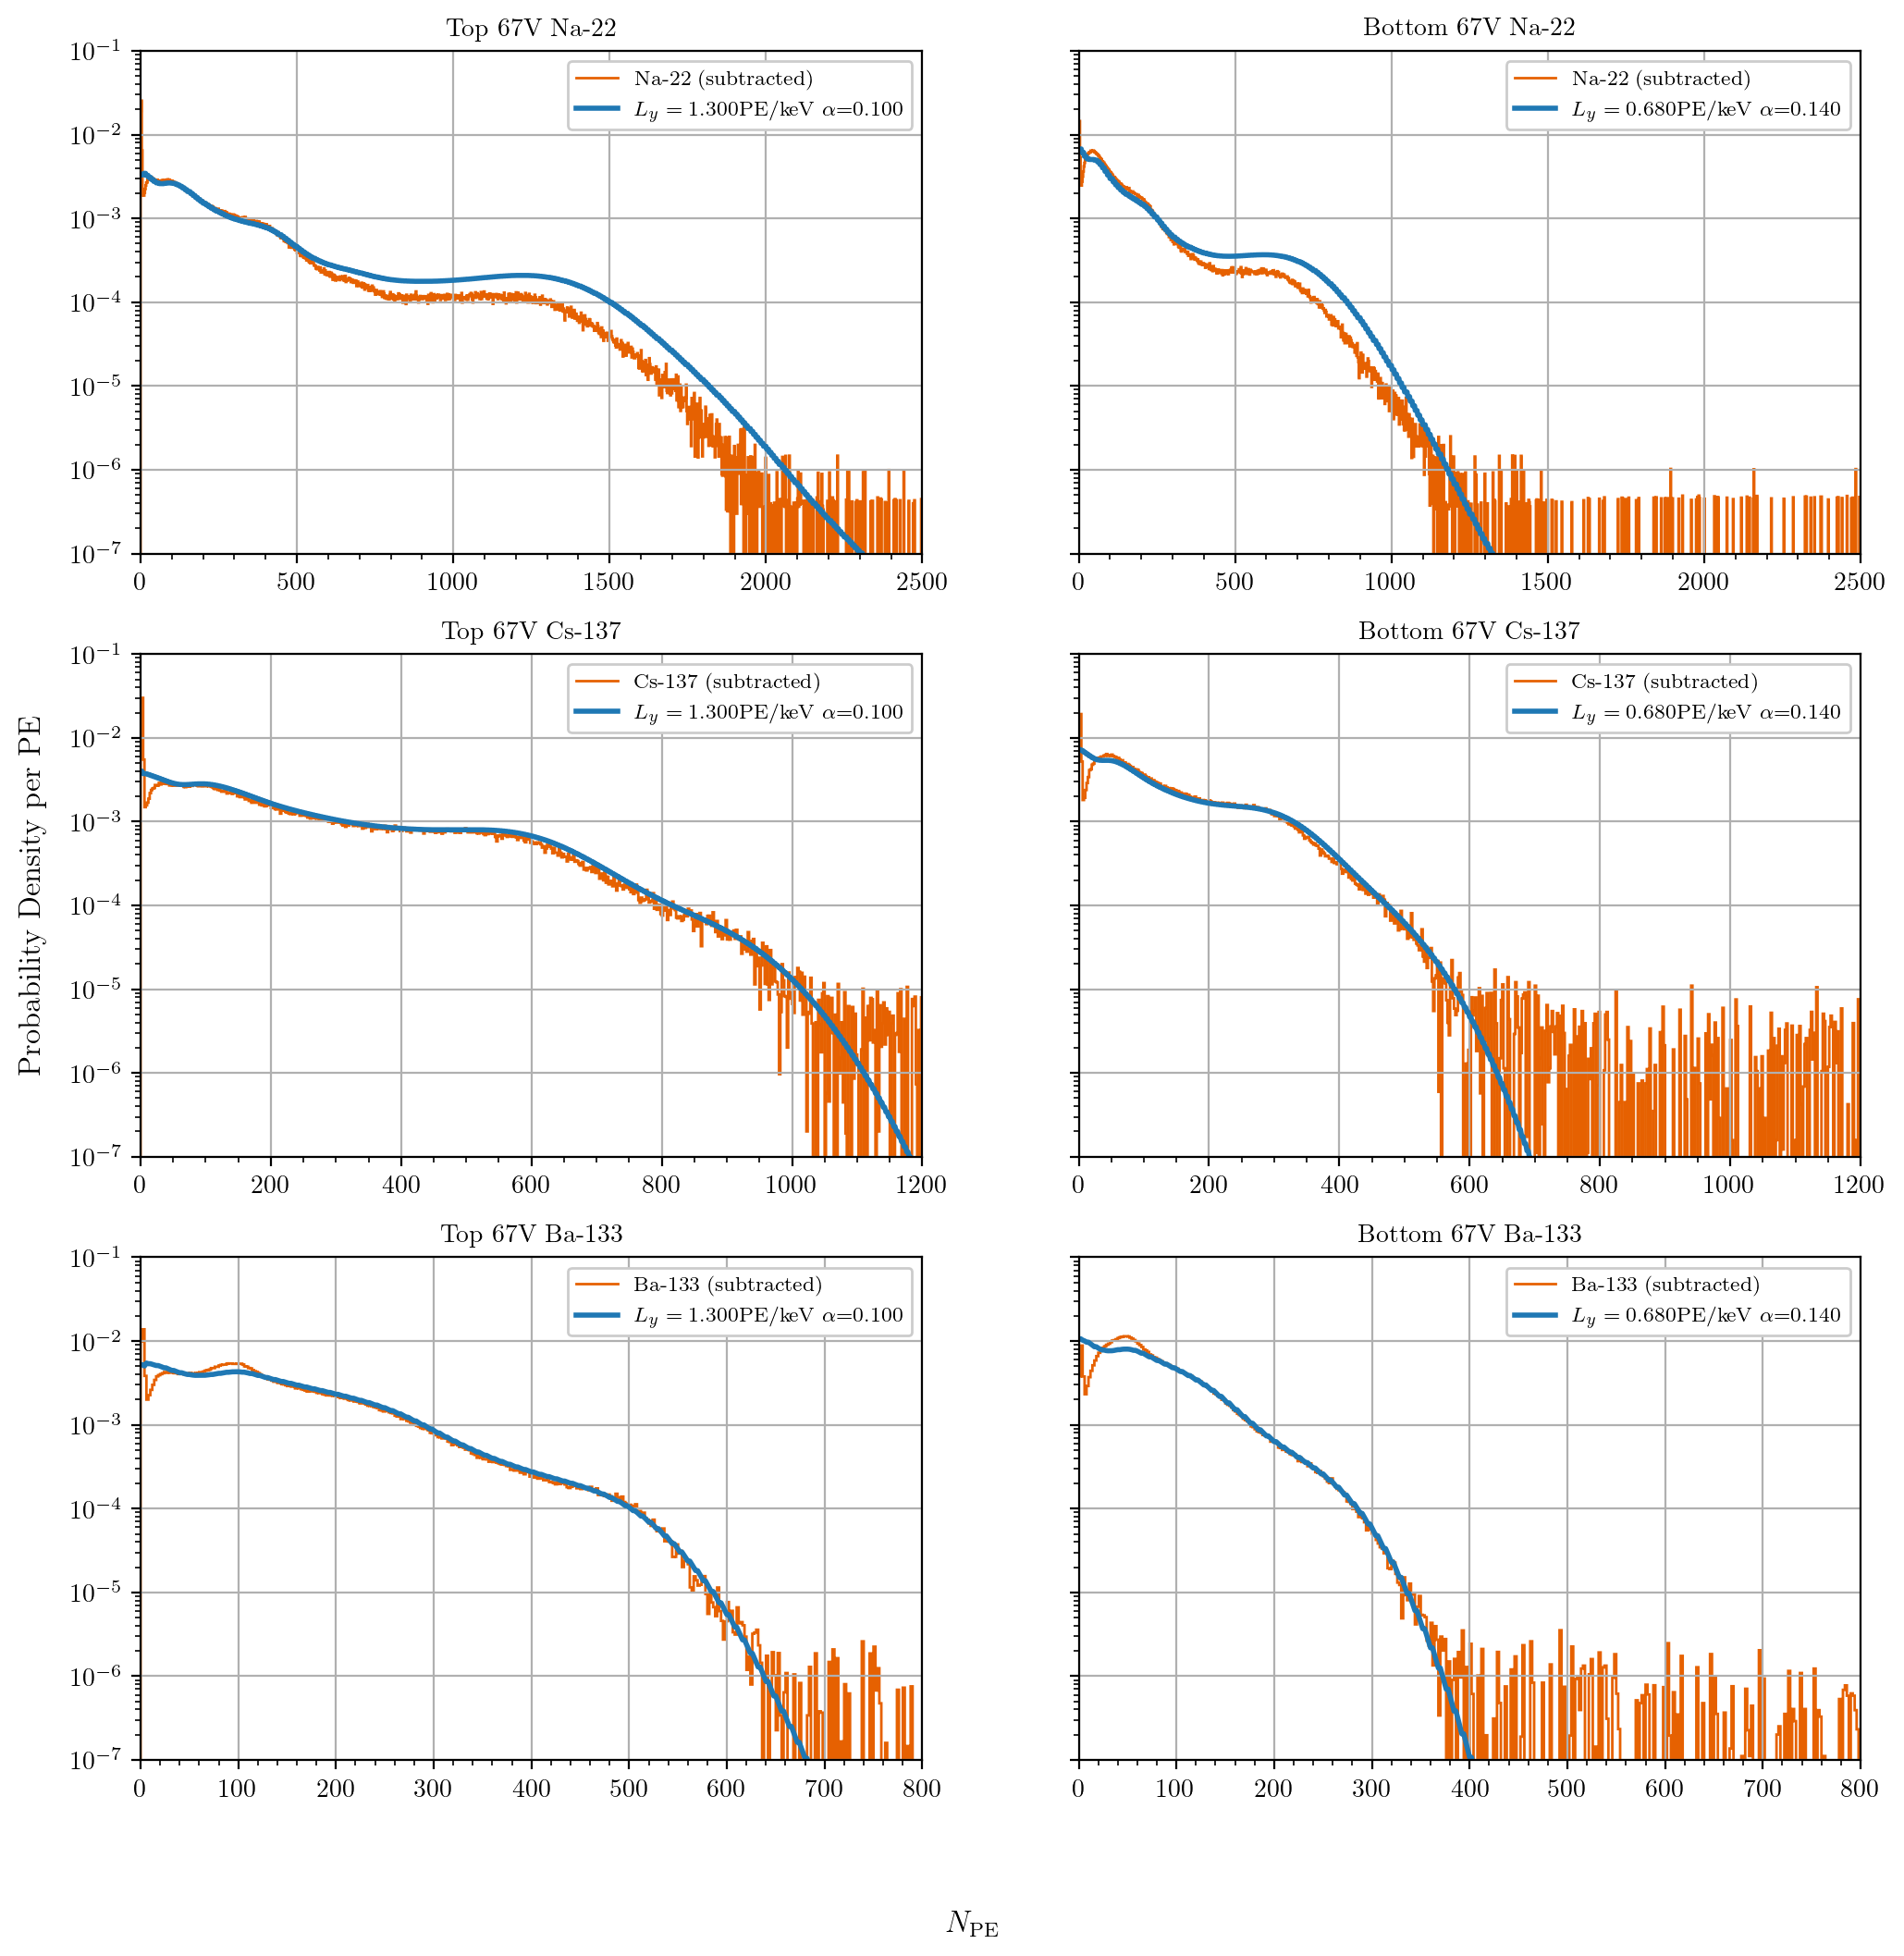

In [25]:
# Make plots for all datasets
# With source, without source, and background subtracted
fig, axs = plt.subplots(3, 2, sharex=False, sharey=True)
fig.set_size_inches(12, 12)
light_yield = {'top':1.3, 'bottom':0.68}
alpha = {'top':0.1, 'bottom':0.14}
max_pe = {'Na-22':2500, 'Cs-137':1200, 'Ba-133':800}
files = {'Na-22':'spectrum_na22_ene.root', 'Cs-137':'spectrum_cs137_ene.root', 'Ba-133':'spectrum_ba133_ene.root'}
for i, pos in enumerate(positions):
    for j, volt in enumerate(voltages):
        for k, t in enumerate(types[-3:]):
            integral = np.sum(spectra[t][pos][volt]['counts'])
            bin_width = spectra[t][pos][volt]['bins'][1]-spectra[t][pos][volt]['bins'][0]
            axs[k, i].stairs(
                spectra[t][pos][volt]['counts']/integral/bin_width,
                spectra[t][pos][volt]['bins'],
                label=f'{t}', color=f'C1'
            )
            model = Spectrum(p_dict[pos][67], pe_max=max_pe[types[k+1]]*1.2, pe_width=max_pe[types[k+1]]/300, root_file_path=f"data/gamma/{files[types[k+1]]}")
            axs[k, i].plot(
                spectra[t][pos][volt]['bins'],
                model.pe_spectrum(spectra[t][pos][volt]['bins'], light_yield[pos], alpha[pos], 1), 
                label=r'$L_y={:.3f}$PE/keV $\alpha$={:.3f}'.format(light_yield[pos], alpha[pos])
            )
            axs[k, i].legend(loc='upper right')
            axs[k, i].set_ylim(1e-7, 1e-1)
            axs[k, i].set_xlim(spectra[t][pos][volt]['bins'][0],max_pe[types[k+1]])
            axs[k, i].set_yscale('log')
            axs[k, i].minorticks_on()
            axs[k, i].grid()
            axs[k, i].set_title(f'{pos[0].upper()}{pos[1:]} {volt}V {types[k+1]}')
fig.supxlabel(r'$N_{\rm PE}$', y=0.03)
fig.supylabel('Probability Density per PE', x=0.07)

## Fit

In [26]:
# Initialize container
spectrum_fit = {}
sources = ['Cs-137', 'Ba-133']
for pos in positions:
    spectrum_fit[pos] = {}
    for s in sources:
        spectrum_fit[pos][s] = {}

In [27]:
ly_guess = {'top':[1.3,1.3], 'bottom':[0.62,0.62]}
fit_min = {'top':[200,200], 'bottom':[100,100]}
fit_max = {'top':[1000,600], 'bottom':[550,360]}
files = ['data/gamma/spectrum_cs137_ene.root','data/gamma/spectrum_ba133_ene.root']
analytic_spectra = {'top':[], 'bottom':[]}
volt = 67
for pos in positions:
    for i,s in enumerate(sources):
        print(f'Running for {pos} {s}')
        # Spectrum fit range
        spectrum_fit[pos][s]['fit_range'] = [fit_min[pos][i], fit_max[pos][i]]
        spectrum_fit[pos][s]['data'] = {
            'bins':spectra[s+' (subtracted)'][pos][volt]['bins'],
            'x':0.5*(spectra[s+' (subtracted)'][pos][volt]['bins'][1:]+spectra[s+' (subtracted)'][pos][volt]['bins'][:-1]), 
            'y':spectra[s+' (subtracted)'][pos][volt]['counts'], 
            'yerr':spectra[s+' (subtracted)'][pos][volt]['errs']
        }
        spec = Spectrum(dict=p_dict[pos][volt],pe_max=spectrum_fit[pos][s]['fit_range'][1]*1.5, pe_width=spectrum_fit[pos][s]['fit_range'][1]/500, root_file_path=files[i])
        analytic_spectra[pos].append(spec)
        in_fit_range = (spectrum_fit[pos][s]['data']['x']>spectrum_fit[pos][s]['fit_range'][0])&(spectrum_fit[pos][s]['data']['x']<spectrum_fit[pos][s]['fit_range'][1])
        spectrum_fit[pos][s]['pars'], spectrum_fit[pos][s]['cov'] = curve_fit(
            spec.pe_spectrum, 
            spectrum_fit[pos][s]['data']['x'][in_fit_range],
            spectrum_fit[pos][s]['data']['y'][in_fit_range],
            p0=[ly_guess[pos][i], 0.1, np.sum(spectrum_fit[pos][s]['data']['y'])],
            sigma=spectrum_fit[pos][s]['data']['yerr'][in_fit_range],
            maxfev=10000)
        # spectrum_fit[pos][s]['chi2'] = {'x': X, 'y':Y, 'z':chi2map}
        spectrum_fit[pos][s]['chi2'] = np.sum(((spectrum_fit[pos][s]['data']['y'][in_fit_range]-spec.pe_spectrum(spectrum_fit[pos][s]['data']['x'][in_fit_range],*spectrum_fit[pos][s]['pars'])) / spectrum_fit[pos][s]['data']['yerr'][in_fit_range]) ** 2)
        spectrum_fit[pos][s]['dof'] = np.sum(in_fit_range)-3
        print(f'chi2={spectrum_fit[pos][s]["chi2"]} dof={spectrum_fit[pos][s]["dof"]}')

        # Print best fit values and 68% CL
        ly_fit = spectrum_fit[pos][s]['pars'][0]
        alpha_fit = spectrum_fit[pos][s]['pars'][1]
        ly_68 = func.error_distance(df=3,sigma=1)*np.sqrt(spectrum_fit[pos][s]['cov'][0,0])
        alpha_68 = func.error_distance(df=3,sigma=1)*np.sqrt(spectrum_fit[pos][s]['cov'][1,1])
        print('Ly={:.3f}+/-{:.3f} PE/keV  alpha={:.3f}+/-{:.3f} (68% CL)'.format(ly_fit, ly_68, alpha_fit, alpha_68))
        spectrum_fit[pos][s]['ly'] = ly_fit
        spectrum_fit[pos][s]['ly_err'] = ly_68
        spectrum_fit[pos][s]['alpha'] = alpha_fit
        spectrum_fit[pos][s]['alpha_err'] = alpha_68

Running for top Cs-137
chi2=427.1456971595523 dof=397
Ly=1.263+/-0.004 PE/keV  alpha=0.116+/-0.005 (68% CL)
Running for top Ba-133
chi2=247.17520066611814 dof=197
Ly=1.313+/-0.004 PE/keV  alpha=0.084+/-0.004 (68% CL)
Running for bottom Cs-137
chi2=344.7522635610438 dof=222
Ly=0.645+/-0.003 PE/keV  alpha=0.168+/-0.006 (68% CL)
Running for bottom Ba-133
chi2=165.07282764005691 dof=127
Ly=0.668+/-0.004 PE/keV  alpha=0.143+/-0.007 (68% CL)


Text(0.02, 0.5, 'Rate [A.U.]')

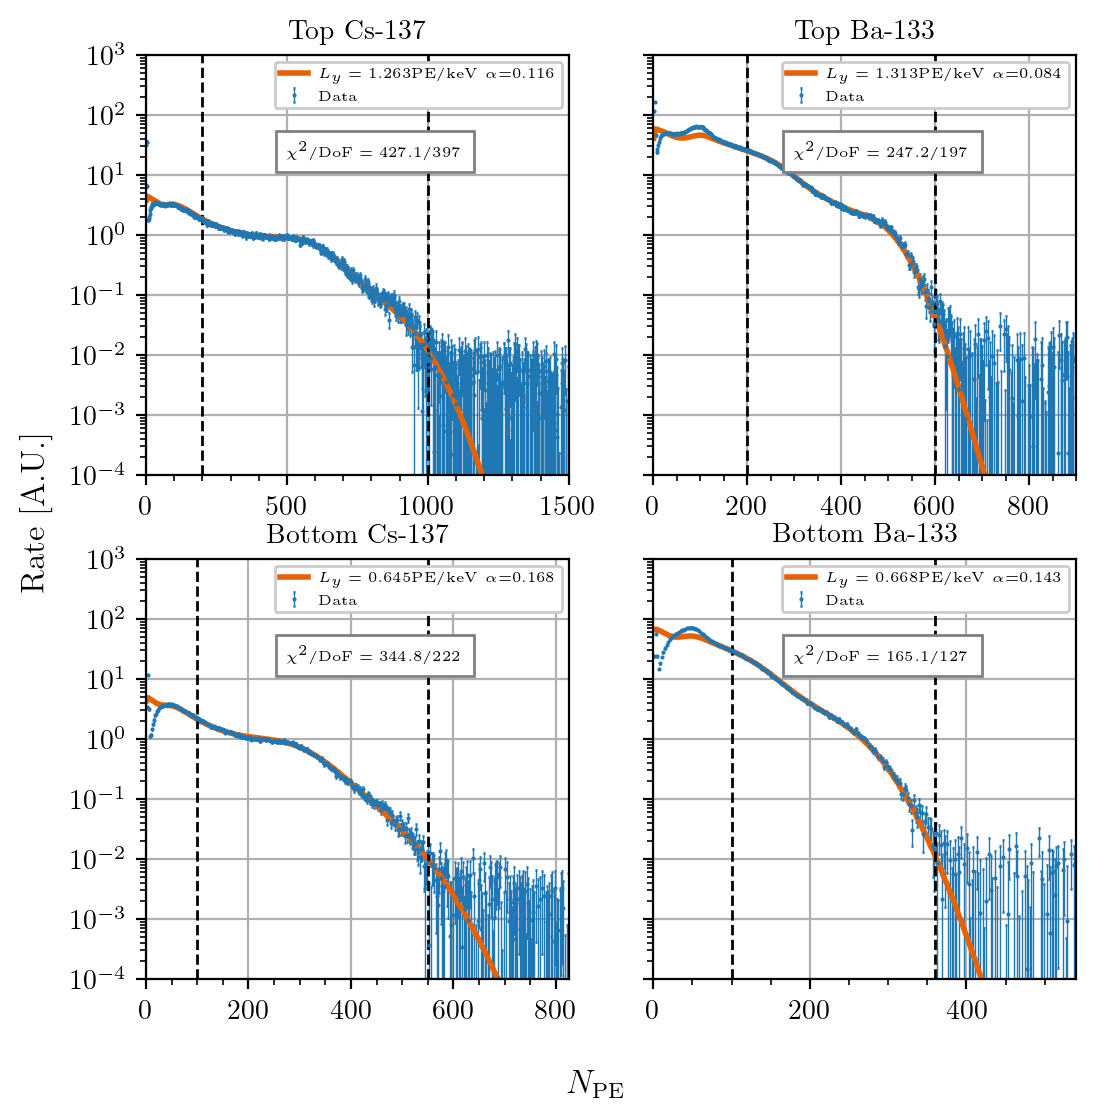

In [28]:
# Make plots for all datasets
# Fitted spectra
fig, axs = plt.subplots(2, 2, sharex=False, sharey=True)
fig.set_size_inches(6, 6)
ymin = 1e-4
ymax = 1e3
for i,pos in enumerate(positions):
    for j,s in enumerate(sources):
        axs[i,j].errorbar(
            spectrum_fit[pos][s]['data']['x'],
            spectrum_fit[pos][s]['data']['y'],
            yerr=spectrum_fit[pos][s]['data']['yerr'],
            fmt='o', label='Data', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5
        )
        axs[i,j].plot(
            spectrum_fit[pos][s]['data']['x'],
            analytic_spectra[pos][j].pe_spectrum(spectrum_fit[pos][s]['data']['x'], *spectrum_fit[pos][s]['pars']), 
            label=r'$L_y={:.3f}$PE/keV $\alpha$={:.3f}'.format(spectrum_fit[pos][s]['ly'], spectrum_fit[pos][s]['alpha'])
        )
        axs[i,j].plot([spectrum_fit[pos][s]['fit_range'][0]]*2, [ymin, ymax], 'k--', linewidth=1)
        axs[i,j].plot([spectrum_fit[pos][s]['fit_range'][1]]*2, [ymin, ymax], 'k--', linewidth=1)
        axs[i,j].text(
            spectrum_fit[pos][s]['fit_range'][1]*0.5, 
            ymax/50, 
            r'$\chi^2/\rm DoF={:.1f}/{:.0f}$'.format(spectrum_fit[pos][s]['chi2'],spectrum_fit[pos][s]['dof']), 
            fontsize=5,bbox=dict(facecolor='white',edgecolor='grey',alpha=1)
        )
        axs[i,j].grid()
        axs[i,j].minorticks_on()
        axs[i,j].set_yscale('log')
        axs[i,j].legend(loc='upper right', fontsize=5)
        axs[i,j].set_xlim(0, spectrum_fit[pos][s]['fit_range'][1]*1.5)
        axs[i,j].set_ylim(ymin, ymax)
        axs[i,j].set_title(f'{pos[0].upper()}{pos[1:]} {s}')
fig.supxlabel(r'$N_{\rm PE}$')
fig.supylabel('Rate [A.U.]')

Text(0, 0.5, 'Rate [A.U.]')

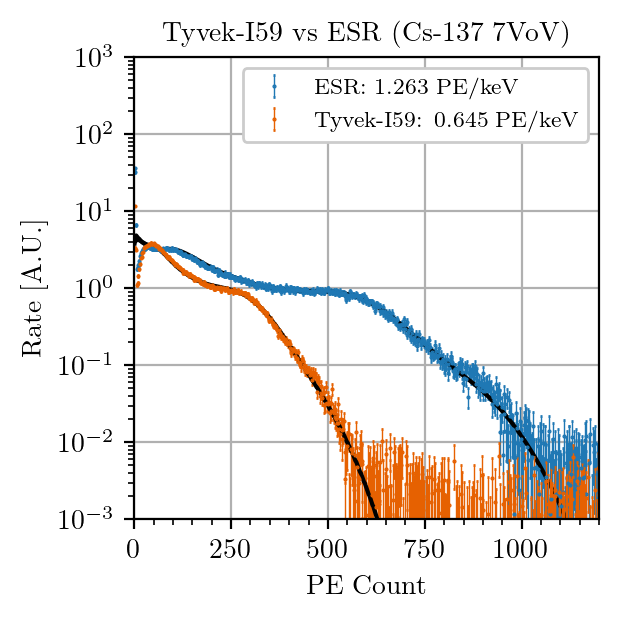

In [30]:
fig, axs = plt.subplots(1, 1, sharex=False, sharey=True)
fig.set_size_inches(3, 3)
ymin = 1e-3
ymax = 1e3
s = 'Cs-137'
j=0
for i,pos in enumerate(positions):
    if pos=='top':
        refl = 'ESR'
    else:
        refl = 'Tyvek-I59'
    axs.errorbar(
        spectrum_fit[pos][s]['data']['x'],
        spectrum_fit[pos][s]['data']['y'],
        yerr=spectrum_fit[pos][s]['data']['yerr'],
        fmt='o', label=f'{refl}: {spectrum_fit[pos][s]["ly"]:.3f} PE/keV', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5, color=f'C{i}'
    )
    axs.plot(
        spectrum_fit[pos][s]['data']['x'],
        analytic_spectra[pos][j].pe_spectrum(spectrum_fit[pos][s]['data']['x'], *spectrum_fit[pos][s]['pars']), 'k-',
        label='_nolegend_',  linewidth=1.5
    )
axs.grid()
axs.minorticks_on()
axs.set_yscale('log')
axs.legend(loc='upper right', fontsize=8)
axs.set_xlim(0, 1200)
axs.set_ylim(ymin, ymax)
axs.set_title(f'Tyvek-I59 vs ESR (Cs-137 7VoV)')
axs.set_xlabel('PE Count')
axs.set_ylabel('Rate [A.U.]')

Text(0, 0.5, 'Rate [A.U.]')

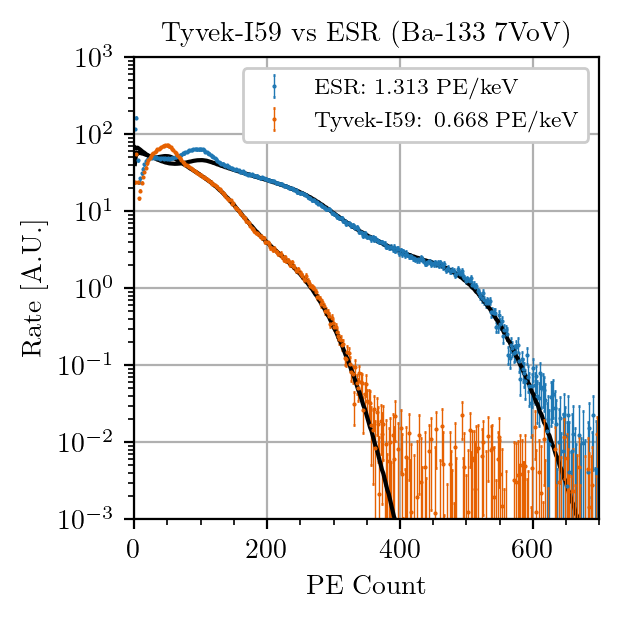

In [32]:
fig, axs = plt.subplots(1, 1, sharex=False, sharey=True)
fig.set_size_inches(3, 3)
ymin = 1e-3
ymax = 1e3
s = 'Ba-133'
j=1
for i,pos in enumerate(positions):
    if pos=='top':
        refl = 'ESR'
    else:
        refl = 'Tyvek-I59'
    axs.errorbar(
        spectrum_fit[pos][s]['data']['x'],
        spectrum_fit[pos][s]['data']['y'],
        yerr=spectrum_fit[pos][s]['data']['yerr'],
        fmt='o', label=f'{refl}: {spectrum_fit[pos][s]["ly"]:.3f} PE/keV', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5, color=f'C{i}'
    )
    axs.plot(
        spectrum_fit[pos][s]['data']['x'],
        analytic_spectra[pos][j].pe_spectrum(spectrum_fit[pos][s]['data']['x'], *spectrum_fit[pos][s]['pars']), 'k-',
        label='_nolegend_',  linewidth=1.5
    )
axs.grid()
axs.minorticks_on()
axs.set_yscale('log')
axs.legend(loc='upper right', fontsize=8)
axs.set_xlim(0, 700)
axs.set_ylim(ymin, ymax)
axs.set_title(f'Tyvek-I59 vs ESR (Ba-133 7VoV)')
axs.set_xlabel('PE Count')
axs.set_ylabel('Rate [A.U.]')

## Top-Bottom Comparison
The error bars for light yield (ratio) here include the contribution from calibration (SPE gain and DiCT probability)

In [33]:
# Initialize container
results = {
    'ly':{
        'ESR':{},'Tyvek':{}
    }, 
    'alpha':{
        'ESR':{},'Tyvek':{}
    },
    'ly_ratio':{
        'theory':{}, 'experiment':{}    
    }
}

Average Tyvek-to-ESR Ly ratio = 0.5096+/-0.0223(stat)+/-0.0012(sys)


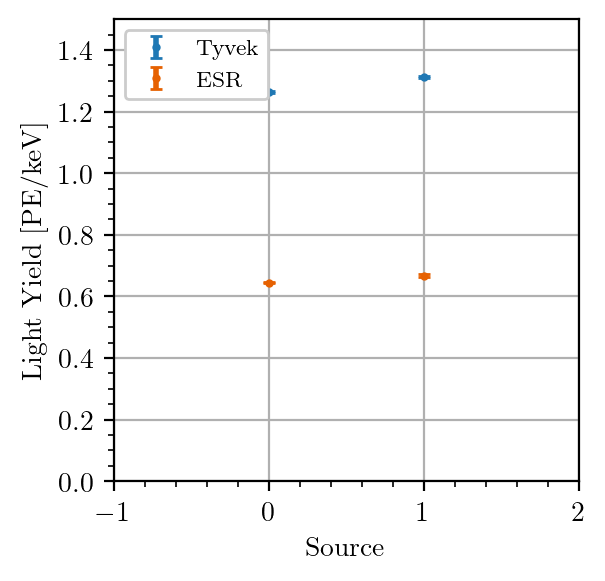

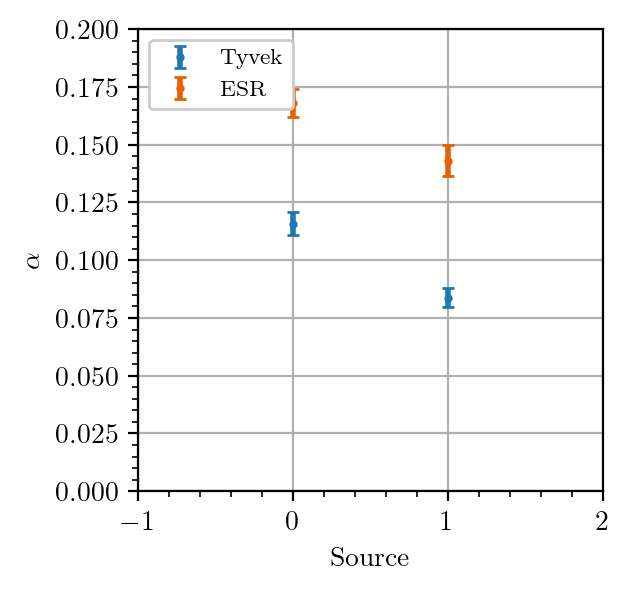

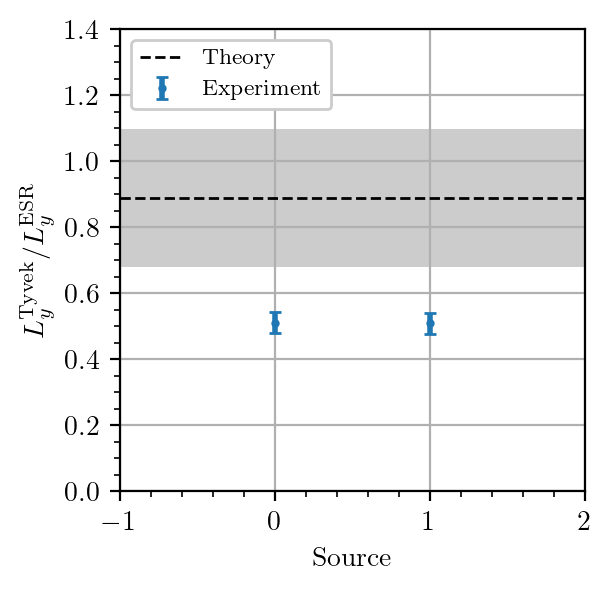

In [40]:
ly_ratio_th = 0.890
ly_ratio_th_err = 0.209
volt=67

for k1 in list(results.keys()):
    for k2,pos in zip(list(results[k1].keys()),positions):
        if k1=='ly' or k1=='alpha':
            results[k1][k2]['x'] = np.array([0,1])
            results[k1][k2]['y'] = np.array([spectrum_fit[pos][s][k1] for s in sources])
            results[k1][k2]['yerr'] = np.array([spectrum_fit[pos][s][k1+'_err'] for s in sources])
        elif k1=='ly_ratio':
            if k2=='theory':
                results[k1][k2]['x'] = np.array([-1, 2])
                results[k1][k2]['y'] = np.array([ly_ratio_th]*2)
                results[k1][k2]['yerr'] = np.array([ly_ratio_th_err]*2)
            elif k2=='experiment':
                results[k1][k2]['x'] = np.array([0, 1])
                results[k1][k2]['y'] = np.array([spectrum_fit['bottom'][s]['ly']/spectrum_fit['top'][s]['ly'] for s in sources])
                results[k1][k2]['yerr'] = np.array([
                (  
                    (spectrum_fit['top'][s]['ly_err']/spectrum_fit['top'][s]['ly'])**2 + 
                    syserr2['top'][volt] + 
                    (spectrum_fit['bottom'][s]['ly_err']/spectrum_fit['bottom'][s]['ly'])**2 + 
                    syserr2['bottom'][volt]
                )**0.5 for s in sources
                ])

plt.figure(1,figsize=(3,3))
labels = {'top':'ESR','bottom':'Tyvek'}
for ref in list(results['ly'].keys()):   
    plt.errorbar(
        results['ly'][ref]['x'],
        results['ly'][ref]['y'],
        yerr=results['ly'][ref]['yerr'], 
        fmt='o', label=ref, ls='none', elinewidth=2, capsize=2, markersize=2
    )
plt.xlabel('Source')
plt.ylabel(r'Light Yield [$\rm PE/keV$]')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.xlim(-1,2)
plt.ylim(0,1.5)

plt.figure(2,figsize=(3,3))
for ref in list(results['alpha'].keys()):   
    plt.errorbar(
        results['alpha'][ref]['x'],
        results['alpha'][ref]['y'],
        yerr=results['alpha'][ref]['yerr'], 
        fmt='o', label=ref, ls='none', elinewidth=2, capsize=2, markersize=2
    )
plt.xlabel('Source')
plt.ylabel(r'$\alpha$')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.xlim(-1,2)
plt.ylim(0,0.2)

plt.figure(3,figsize=(3,3))
plt.errorbar(
    results['ly_ratio']['experiment']['x'],
    results['ly_ratio']['experiment']['y'],
    yerr=results['ly_ratio']['experiment']['yerr'], 
    fmt='o', label='Experiment', ls='none', elinewidth=2, capsize=2, markersize=2
)
plt.fill_between(
    x=results['ly_ratio']['theory']['x'],
    y1=results['ly_ratio']['theory']['y']-results['ly_ratio']['theory']['yerr'], 
    y2=results['ly_ratio']['theory']['y']+results['ly_ratio']['theory']['yerr'],
    facecolor='k',alpha=0.2
)
plt.plot(
    results['ly_ratio']['theory']['x'], 
    results['ly_ratio']['theory']['y'], 
    'k--', label='Theory', linewidth=1
)
plt.xlabel('Source')
plt.ylabel(r'$L_{y}^{\rm Tyvek}/L_{y}^{\rm ESR}$')
plt.grid()
plt.minorticks_on()
plt.legend()
plt.xlim(-1,2)
plt.ylim(0,1.4)

# Weighted average and statistical uncertainty
lyr_mu = np.sum(results['ly_ratio']['experiment']['y']/results['ly_ratio']['experiment']['yerr']**2) \
    /np.sum(1/results['ly_ratio']['experiment']['yerr']**2)
lyr_sigma = 1/np.sqrt(np.sum(1/results['ly_ratio']['experiment']['yerr']**2))
# RMS variation -> "systematic" uncertainty
lyr_rms = np.std(results['ly_ratio']['experiment']['y'], ddof=1)
print(f'Average Tyvek-to-ESR Ly ratio = {lyr_mu:.4f}+/-{lyr_sigma:.4f}(stat)+/-{lyr_rms:.4f}(sys)')


# Coincidence settings

In [42]:
# Coincidence table
#      high trg rate <---------> low trg rate
# c0-3 OOO  AOO  OAO  OOA  AAO  AOA  OAA  AAA

# 0000 ---  ---  ---  ---  ---  ---  ---  --- 
# 1000 OOO  ---  OAO  ---  ---  ---  ---  --- 
# 0100 OOO  ---  OAO  ---  ---  ---  ---  --- 
# 0010 OOO  AOO  ---  ---  ---  ---  ---  ---
# 0001 OOO  AOO  ---  ---  ---  ---  ---  --- 
# 1100 OOO  AOO  OAO  ---  AAO  ---  ---  --- 
# 1010 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 1001 OOO  AOO  OAO  OOA  ---  ---  ---  --- 
# 0110 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 0101 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 0011 OOO  AOO  OAO  ---  AAO  ---  ---  ---
# 1110 OOO  AOO  OAO  OOA  AAO  AOA  ---  --- 
# 1101 OOO  AOO  OAO  OOA  AAO  AOA  ---  --- 
# 1011 OOO  AOO  OAO  OOA  AAO  ---  OAA  --- 
# 0111 OOO  AOO  OAO  OOA  AAO  ---  OAA  --- 
# 1111 OOO  AOO  OAO  OOA  AAO  AOA  OAA  AAA 

In [94]:
# data folder
data = {}
coinc = ['000', '100', '010', '001', '110', '101', '011', '111']
path = "/scratch/gpfs/as111/results/2023-05-01/"
channels = [-1,0,1,2,3]
for c in coinc:
    data[c] = {}
    files = glob.glob(f"{path}*coinc_{c}*[!_wf].h5")
    print(files)
    for ch in channels:
        data[c][ch] = []
        for f in files:
            df = pd.read_hdf(f, key=f'67/{ch}')
            data[c][ch].append(df)
            df = None
        data[c][ch] = pd.concat(data[c][ch], ignore_index=True)
print('keys: ', list(data['000'][0].keys()))
print(f'{len(data["000"][0])} events')

['/scratch/gpfs/as111/results/2023-05-01/2023-05-01_volt_67_pos_top_light_scintillation_coinc_000_cond_no_gamma_run0.h5']
['/scratch/gpfs/as111/results/2023-05-01/2023-05-01_volt_67_pos_top_light_scintillation_coinc_100_cond_no_gamma_run0.h5']
['/scratch/gpfs/as111/results/2023-05-01/2023-05-01_volt_67_pos_top_light_scintillation_coinc_010_cond_no_gamma_run0.h5']
['/scratch/gpfs/as111/results/2023-05-01/2023-05-01_volt_67_pos_top_light_scintillation_coinc_001_cond_no_gamma_run0.h5']
['/scratch/gpfs/as111/results/2023-05-01/2023-05-01_volt_67_pos_top_light_scintillation_coinc_110_cond_no_gamma_run0.h5']
['/scratch/gpfs/as111/results/2023-05-01/2023-05-01_volt_67_pos_top_light_scintillation_coinc_101_cond_no_gamma_run0.h5']
['/scratch/gpfs/as111/results/2023-05-01/2023-05-01_volt_67_pos_top_light_scintillation_coinc_011_cond_no_gamma_run0.h5']
['/scratch/gpfs/as111/results/2023-05-01/2023-05-01_volt_67_pos_top_light_scintillation_coinc_111_cond_no_gamma_run0.h5']
keys:  ['baseline_mean',

In [95]:
# Initialize container
baseline = {}
for c in coinc:
    baseline[c] = {}
    for ch in channels:
        baseline[c][ch] = {}

In [96]:
# Produce baseline rms histograms
nbins = 500
range_min = 0
range_max = 10
for c in coinc:
    for ch in channels[1:]:
        baseline[c][ch]['rms_counts'], baseline[c][ch]['rms_bins'] = np.histogram(data[c][ch]['baseline_rms'], bins=nbins, range=(range_min, range_max))
        if ch==1:
            baseline[c][ch]['rms_threshold'] = 3
        else:
            baseline[c][ch]['rms_threshold'] = 2.5

In [97]:
# Produce baseline mean histograms
nbins = 500
range_min = 3700
range_max = 3800
for c in coinc:
    for ch in channels[1:]:
        baseline[c][ch]['mean_counts'], baseline[c][ch]['mean_bins'] = np.histogram(
            data[c][ch]['baseline_mean'], 
            bins=nbins, range=(range_min, range_max)
        )
        baseline[c][ch]['mean_counts_cut'], baseline[c][ch]['mean_bins_cut'] = np.histogram(
            data[c][ch].loc[data[c][ch]['baseline_rms']<baseline[c][ch]['rms_threshold'],'baseline_mean'], # cut on baseline rms
            bins=nbins, range=(range_min, range_max)
        )

Text(0.07, 0.5, 'Count')

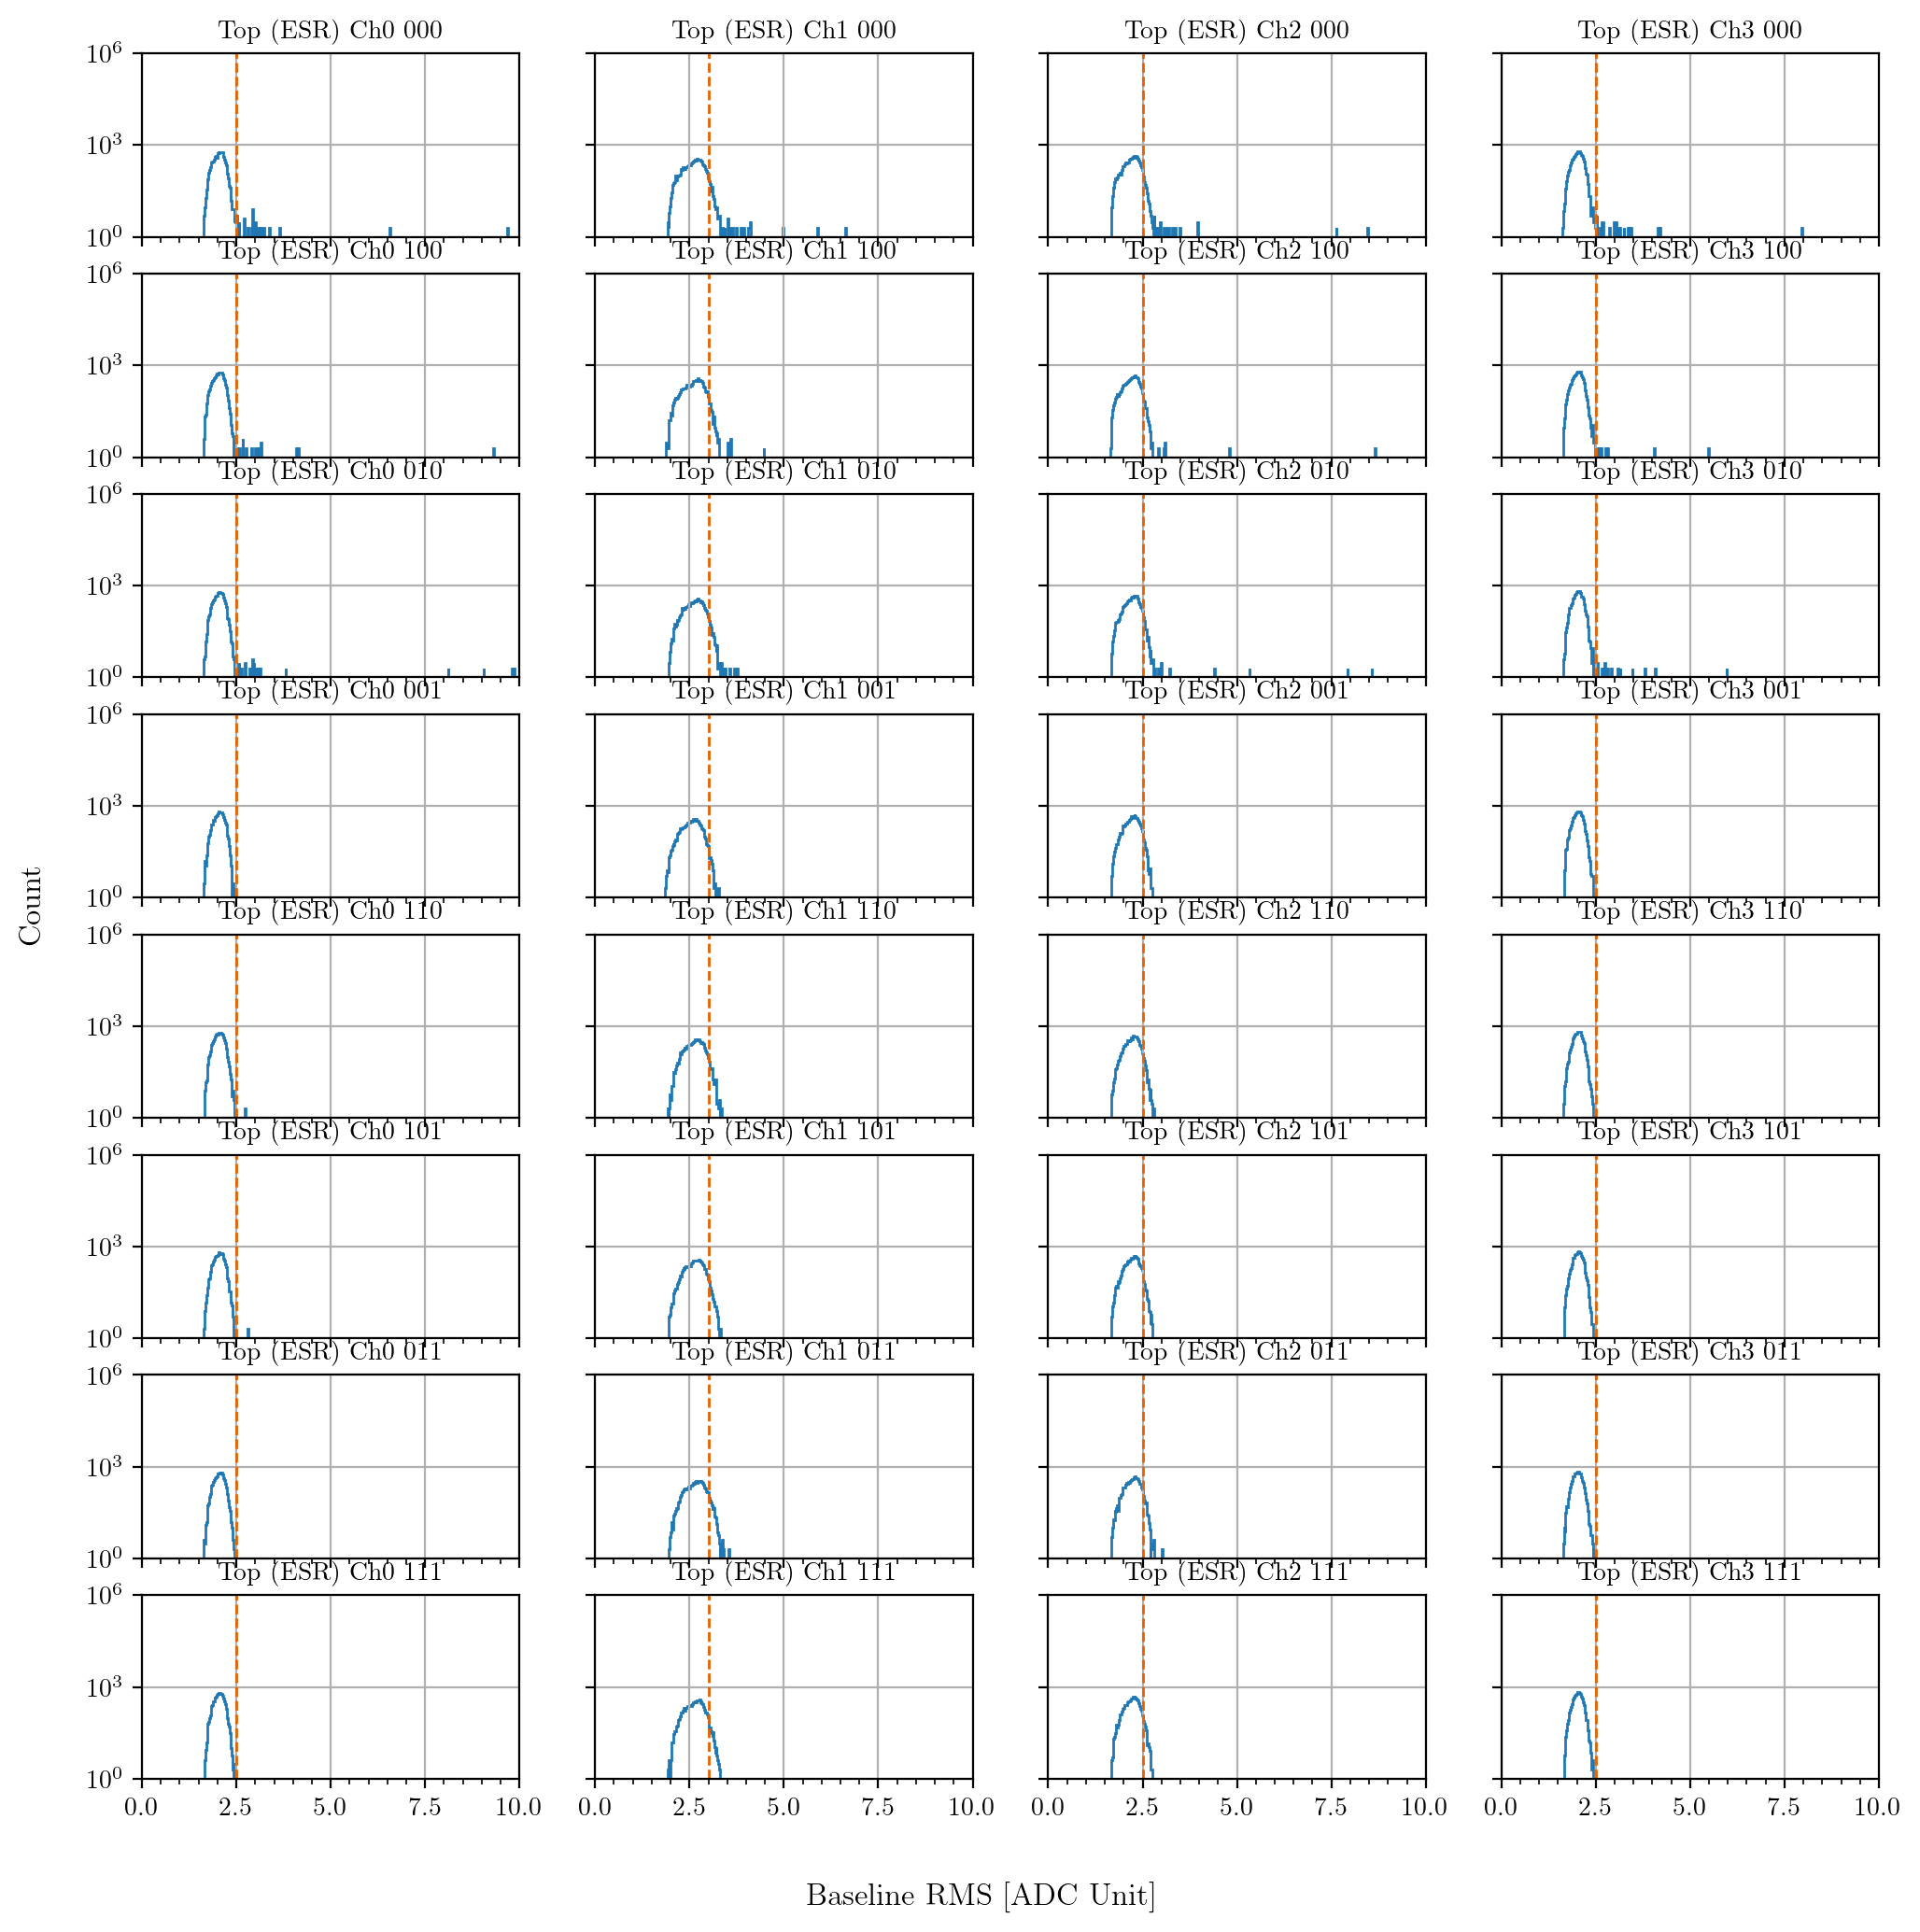

In [98]:
# Make plots for all datasets
# Baseline RMS
fig, axs = plt.subplots(8, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 12)
for i, c in enumerate(coinc):
    for k, ch in enumerate(channels[1:]):
        axs[i,k].stairs(
            baseline[c][ch]['rms_counts'],
            baseline[c][ch]['rms_bins'],
        )
        th = baseline[c][ch]['rms_threshold']
        axs[i,k].plot([th, th], [1, 1e6], f'--', linewidth=1)
        axs[i,k].set_ylim(1, 1e6)
        axs[i,k].set_yscale('log')
        axs[i,k].minorticks_on()
        axs[i,k].grid()
        axs[i,k].set_title(f'Top (ESR) Ch{ch} {c}')
fig.supxlabel('Baseline RMS [ADC Unit]', y=0.05)
fig.supylabel('Count', x=0.07)

In [99]:
# Calculate cut fraction
data_aggr_nocut = {}
data_aggr_bslcut = {}
for c in coinc:
    # combine total_pe, fprompt, and baseline rms for each channel into a single DF
    data_aggr_nocut[c] = np.vstack((
        data[c][-1]['total_pe'],
        data[c][-1]['fprompt'],
        data[c][0]['baseline_rms'],
        data[c][1]['baseline_rms'],
        data[c][2]['baseline_rms'],
        data[c][3]['baseline_rms']
    )).T
    for ch in channels:
        data[c][ch] = None # clear memory
        data_aggr_nocut[c] = pd.DataFrame(
            data_aggr_nocut[c],
            columns=['total_pe','fprompt','baseline_rms0','baseline_rms1','baseline_rms2','baseline_rms3']
        )
        # apply baseline cut on all channels
        data_aggr_bslcut[c] = data_aggr_nocut[c].loc[ 
            (data_aggr_nocut[c]['baseline_rms0']<baseline[c][0]['rms_threshold']) & 
            (data_aggr_nocut[c]['baseline_rms1']<baseline[c][1]['rms_threshold']) & 
            (data_aggr_nocut[c]['baseline_rms2']<baseline[c][2]['rms_threshold']) & 
            (data_aggr_nocut[c]['baseline_rms3']<baseline[c][3]['rms_threshold'])
        ]
        cut_fraction = 1-data_aggr_bslcut[c].shape[0]/data_aggr_nocut[c].shape[0]
    data_aggr_nocut[c] = None # clear memory
    baseline[c][-1]['cut_fraction'] = cut_fraction
    print(f'{c} cut fraction = {cut_fraction*100:.5f}%')
# clear memory
data = None
data_aggr_nocut = None

000 cut fraction = 8.13816%
100 cut fraction = 6.68499%
010 cut fraction = 7.69918%
001 cut fraction = 4.29533%
110 cut fraction = 5.64235%
101 cut fraction = 5.42103%
011 cut fraction = 7.98690%
111 cut fraction = 5.13153%


In [100]:
# Initialize container
fprompt = {}
for c in coinc:
    fprompt[c] = {}

In [46]:
# Initialize container
spectra_coinc = {}
for c in coinc:
    spectra_coinc[c] = {}

In [102]:
# Produce fprompt 2D histograms
nbinsx = 500
range_minx = -10
range_maxx = 800
nbinsy = 500
range_miny = -0.1
range_maxy = 1

for c in coinc:   
    fprompt[c]['fp_counts'], fprompt[c]['fp_xbins'], fprompt[c]['fp_ybins'] = np.histogram2d(
        data_aggr_bslcut[c]['total_pe'], 
        data_aggr_bslcut[c]['fprompt'], 
        bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
    )
    fprompt[c]['fp_counts'] = fprompt[c]['fp_counts'].T
    fprompt[c]['fp_xbins'], fprompt[c]['fp_ybins'] = np.meshgrid(
        fprompt[c]['fp_xbins'], fprompt[c]['fp_ybins']
    )
    fprompt[c]['fp_threshold'] = 0.1

Text(0.07, 0.5, '$F_{\\rm prompt}$')

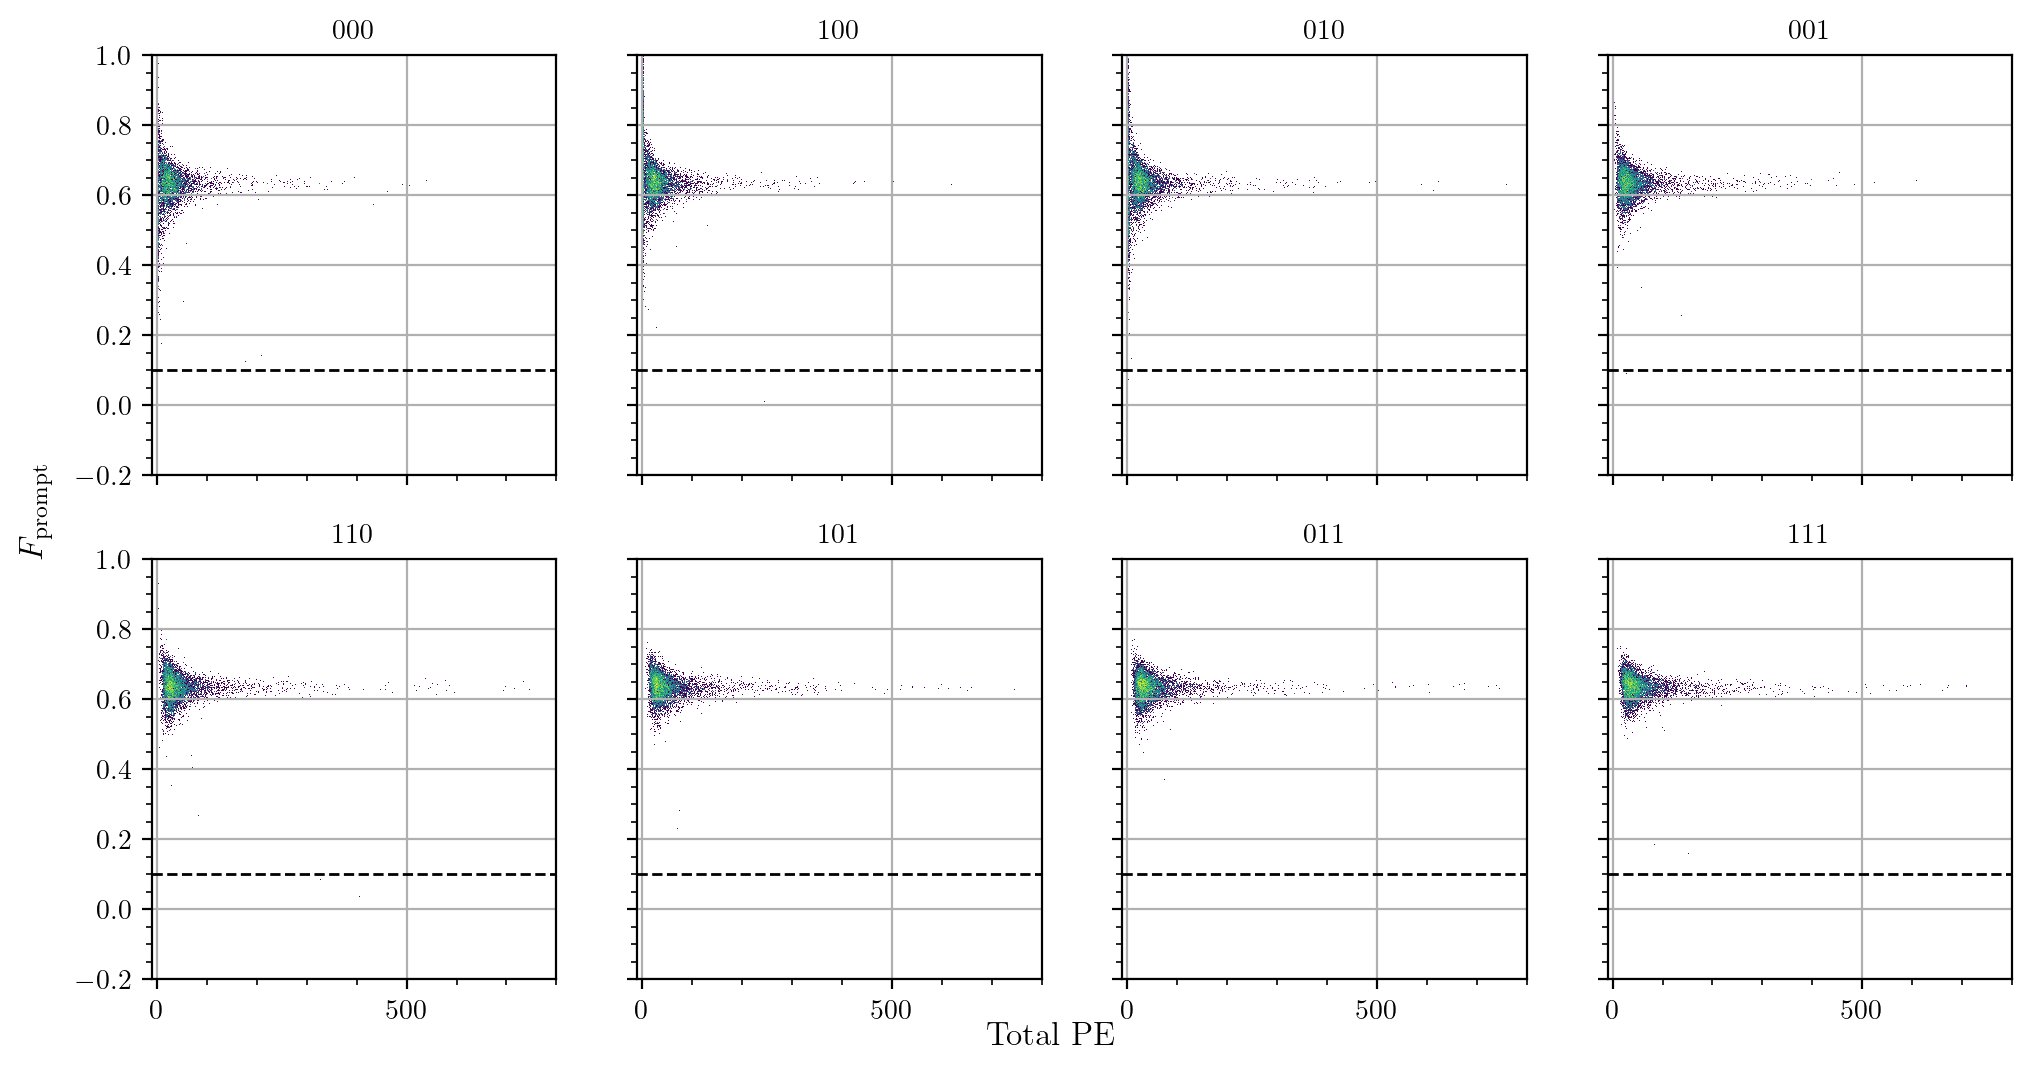

In [108]:
# Make plots for all datasets
# Fprompt
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, c in enumerate(coinc):
    axs[int(i/4), i%4].pcolormesh(
        fprompt[c]['fp_xbins'],
        fprompt[c]['fp_ybins'],
        np.log10(fprompt[c]['fp_counts'])
    )
    th = fprompt[c]['fp_threshold']
    axs[int(i/4), i%4].plot([-10, 800], [th, th], f'k--', linewidth=1)
    axs[int(i/4), i%4].set_xlim(-10, 800)
    axs[int(i/4), i%4].minorticks_on()
    axs[int(i/4), i%4].grid()
    axs[int(i/4), i%4].set_title(f'{c}')
fig.supxlabel('Total PE', y=0.05)
fig.supylabel(r'$F_{\rm prompt}$', x=0.07)

Fprompt (0.5us) is higher than usual because the scintillation light is quenched and shortened.

In [47]:
xmin = -100
xmax = 2000
nbins = 500
norm_bound = 200

for c in coinc:
    spectra_coinc[c]['counts'],spectra_coinc[c]['bins'] = np.histogram(data[c]['total_pe'], bins=nbins, range=(xmin, xmax))
    data[c] = None
    spectra_coinc[c]['norm_bound'] = norm_bound
    spectra_coinc[c]['norm'] = np.dot(spectra_coinc[c]['bins'][:-1]>norm_bound, spectra_coinc[c]['counts'])
data = None

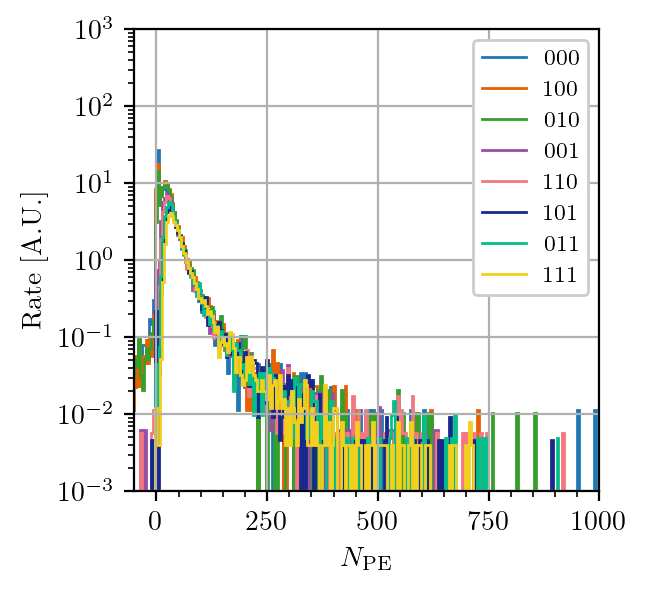

In [49]:
plt.figure(0,figsize=(3,3))
for c in coinc:
    plt.stairs(
        spectra_coinc[c]['counts']/spectra_coinc[c]['norm'], 
        spectra_coinc[c]['bins'], 
        label=c
    )
    
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel(r'$N_{\rm PE}$')
plt.legend(loc='upper right')
plt.xlim(-50,1000)
plt.ylim(1e-3,1e3)
plt.minorticks_on()
plt.grid()

# Source position

In [9]:
# data folder
data = {}
path = "/scratch/gpfs/as111/results/2023-05-09/"
channels = [-1,0,1,2,3]
degrees = ['0','90','180','270']
for deg in degrees:
    data[deg] = []
    files = glob.glob(f"{path}*_{deg}deg*[!_wf].h5")
    print(files)
    for f in files:
        df = pd.read_hdf(f, key=f'67/{-1}')
        data[deg].append(df)
        df = None
    data[deg] = pd.concat(data[deg], ignore_index=True)
print('keys: ', list(data['0'].keys()))
print(f'{len(data["0"])} events')

['/scratch/gpfs/as111/results/2023-05-09/2023-05-09_volt_67_pos_bottom_light_scintillation_coinc_001_cond_gamma_ba133_0deg_run0.h5']
['/scratch/gpfs/as111/results/2023-05-09/2023-05-09_volt_67_pos_bottom_light_scintillation_coinc_001_cond_gamma_ba133_90deg_run0.h5']
['/scratch/gpfs/as111/results/2023-05-09/2023-05-09_volt_67_pos_bottom_light_scintillation_coinc_001_cond_gamma_ba133_180deg_run0.h5']
['/scratch/gpfs/as111/results/2023-05-09/2023-05-09_volt_67_pos_bottom_light_scintillation_coinc_001_cond_gamma_ba133_270deg_run0.h5']
keys:  ['start_datetime', 'end_datetime', 'duration_seconds', 'total_pe', 'fprompt']
50724 events


In [10]:
xmin = -100
xmax = 2000
nbins = 1000
norm_bound = 250
spectra = {}
for deg in degrees:
    spectra[deg] = {}
    spectra[deg]['counts'],spectra[deg]['bins'] = np.histogram(data[deg]['total_pe'], bins=nbins, range=(xmin, xmax))
    data[deg] = None
    spectra[deg]['norm_bound'] = norm_bound
    spectra[deg]['norm'] = np.dot(spectra[deg]['bins'][:-1]>norm_bound, spectra[deg]['counts'])
data = None

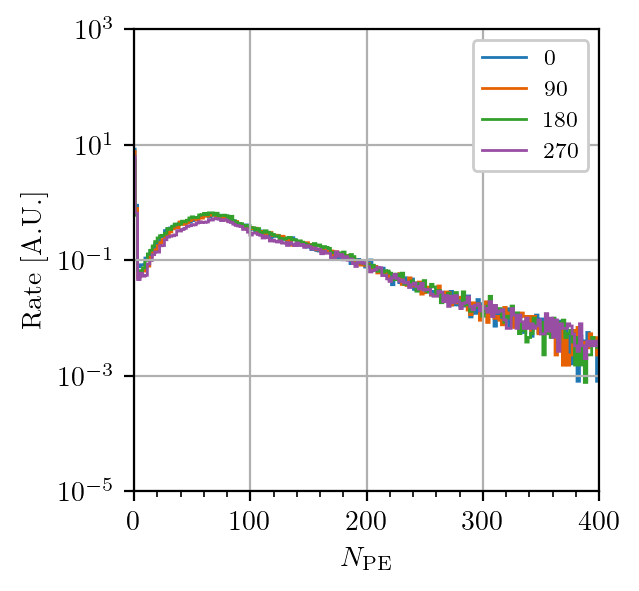

In [12]:
plt.figure(0,figsize=(3,3))
for deg in degrees:
    plt.stairs(
        spectra[deg]['counts']/spectra[deg]['norm'], 
        spectra[deg]['bins'], 
        label=deg
    )
    
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel(r'$N_{\rm PE}$')
plt.legend(loc='upper right')
plt.xlim(0,400)
plt.ylim(1e-5,1e3)
plt.minorticks_on()
plt.grid()

# 5/10 All gama sources

In [164]:
# data folder
data = {}
path = "/scratch/gpfs/as111/results/2023-05-10/"
sources = ['ba133', 'cs137', 'co60', 'na22', 'eu152']
for s in sources:
    print(s)
    data[s] = []
    files = glob.glob(f"{path}*gamma_{s}*[!_wf].h5")
    print(files)
    for f in files:
        df = pd.read_hdf(f, key=f'67/{-1}')
        data[s].append(df)
        df = None
    data[s] = pd.concat(data[s], ignore_index=True)
    print('keys: ', list(data[s].keys()))
    print(f'{len(data[s])} events')

ba133
['/scratch/gpfs/as111/results/2023-05-10/2023-05-10_volt_67_pos_bottom_light_scintillation_coinc_001_cond_gamma_ba133_run9.h5', '/scratch/gpfs/as111/results/2023-05-10/2023-05-10_volt_67_pos_bottom_light_scintillation_coinc_001_cond_gamma_ba133_run3.h5', '/scratch/gpfs/as111/results/2023-05-10/2023-05-10_volt_67_pos_bottom_light_scintillation_coinc_001_cond_gamma_ba133_run4.h5', '/scratch/gpfs/as111/results/2023-05-10/2023-05-10_volt_67_pos_bottom_light_scintillation_coinc_001_cond_gamma_ba133_run8.h5', '/scratch/gpfs/as111/results/2023-05-10/2023-05-10_volt_67_pos_bottom_light_scintillation_coinc_001_cond_gamma_ba133_run7.h5', '/scratch/gpfs/as111/results/2023-05-10/2023-05-10_volt_67_pos_bottom_light_scintillation_coinc_001_cond_gamma_ba133_run1.h5', '/scratch/gpfs/as111/results/2023-05-10/2023-05-10_volt_67_pos_bottom_light_scintillation_coinc_001_cond_gamma_ba133_run2.h5', '/scratch/gpfs/as111/results/2023-05-10/2023-05-10_volt_67_pos_bottom_light_scintillation_coinc_001_cond

## Backgrounds

In [165]:
# data folder
data_bkg = []
path = "/scratch/gpfs/as111/results/2023-05-10/"
files = glob.glob(f"{path}*cond_no_gamma*[!_wf].h5")
print(files)
for f in files:
    df = pd.read_hdf(f, key=f'67/{-1}')
    data_bkg.append(df)
    df = None
data_bkg = pd.concat(data_bkg, ignore_index=True)
print('keys: ', list(data_bkg.keys()))
print(f'{len(data_bkg)} events')

['/scratch/gpfs/as111/results/2023-05-10/2023-05-10_volt_67_pos_bottom_light_scintillation_coinc_001_cond_no_gamma_run3.h5', '/scratch/gpfs/as111/results/2023-05-10/2023-05-10_volt_67_pos_bottom_light_scintillation_coinc_001_cond_no_gamma_run1.h5', '/scratch/gpfs/as111/results/2023-05-10/2023-05-10_volt_67_pos_bottom_light_scintillation_coinc_001_cond_no_gamma_run4.h5', '/scratch/gpfs/as111/results/2023-05-10/2023-05-10_volt_67_pos_bottom_light_scintillation_coinc_001_cond_no_gamma_run2.h5', '/scratch/gpfs/as111/results/2023-05-10/2023-05-10_volt_67_pos_bottom_light_scintillation_coinc_001_cond_no_gamma_run0.h5']
keys:  ['start_datetime', 'end_datetime', 'duration_seconds', 'total_pe', 'fprompt']
250541 events


In [166]:
xmin = -100
xmax = 3000
nbins = 500
norm_bound = 2000
spectrum = {}
spectrum_bkg = {}

# background histogram
spectrum_bkg['counts'],spectrum_bkg['bins'] = np.histogram(data_bkg['total_pe'], bins=nbins, range=(xmin, xmax))
spectrum_bkg['norm_bound'] = norm_bound
spectrum_bkg['norm'] = np.dot(spectrum_bkg['bins'][:-1]>spectrum_bkg['norm_bound'], spectrum_bkg['counts'])
# gamma histograms
for s in sources:
    spectrum[s] = {}
    spectrum[s]['counts'],spectrum[s]['bins'] = np.histogram(data[s]['total_pe'], bins=nbins, range=(xmin, xmax))
    data[s] = None
    spectrum[s]['norm_bound'] = norm_bound
    spectrum[s]['norm'] = np.dot(spectrum[s]['bins'][:-1]>spectrum[s]['norm_bound'], spectrum[s]['counts'])
    spectrum[s]['counts'] = spectrum[s]['counts']/spectrum[s]['norm'] - spectrum_bkg['counts']/spectrum_bkg['norm']
data = None


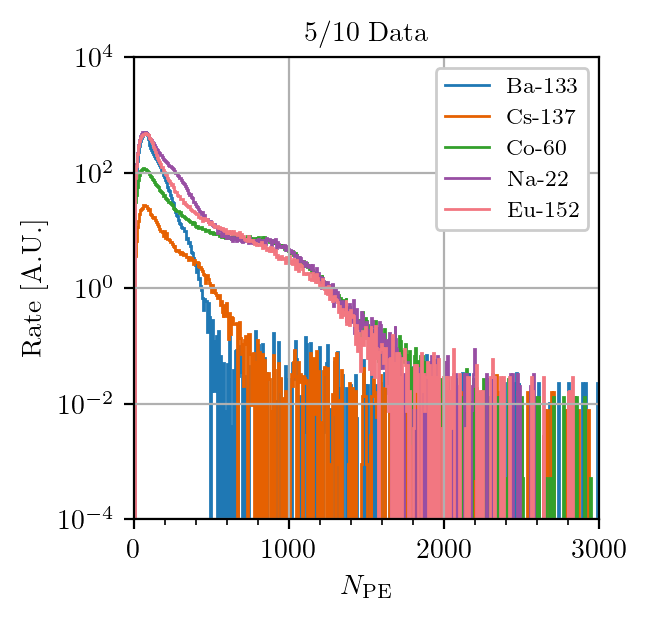

In [168]:
plt.figure(0,figsize=(3,3))
for s in sources:
    plt.stairs(
        spectrum[s]['counts'], 
        spectrum[s]['bins'], 
        label=f'{s[0].upper()}{s[1:2]}-{s[2:]}'
    )
    
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel(r'$N_{\rm PE}$')
plt.title('5/10 Data')
plt.legend(loc='upper right')
plt.xlim(0,3000)
plt.ylim(1e-4,1e4)
plt.minorticks_on()
plt.grid()